In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .tanh()
        .rolling_mean(window)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_expr(
            col=column,
            scaled_col=f"{column}_zd",
            window=window
        ) for column in columns_to_normalize
    ]) 

def z_score_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
            (pl.col(col) - pl.col(col)
             .rolling_mean(window, min_samples=1)
             .fill_null(strategy="zero"))
            / (pl.col(col)
               .rolling_std(window, min_samples=1)
               .fill_nan(0) + 1e-6)
    ).fill_null(0).clip(-2.0, 2.0).alias(scaled_col)


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
symbol = "ethusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)
# origin_df = pl.read_parquet("C:/quant/data/data_test/ethusdt_thresh0.002_hybrid.parquet")

# # 先把那两列单独 shift
# shifted_cols = origin_df.select([
#     pl.col("raw_factor_buy_sell_vlm_diff").shift(-5).alias("raw_factor_buy_sell_vlm_diff_shifted"),
#     pl.col("z_factor_buy_sell_vlm_diff").shift(-5).alias("z_factor_buy_sell_vlm_diff_shifted"),
# ])

# 删除原来的两列
# origin_df = origin_df.drop([ "z_factor_buy_sell_vlm_diff"])

# # 合并回去（按顺序拼接）
# origin_df = origin_df.with_columns([
#     shifted_cols["raw_factor_buy_sell_vlm_diff_shifted"],
#     shifted_cols["z_factor_buy_sell_vlm_diff_shifted"]
# ])
feat_trans_window = 200
feat_trans_lag = 10
feat_norm_window = 500
print(origin_df)
step = 300

origin_df = origin_df.with_columns([
    future_return_expr("px", step),
])
print(origin_df)

origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lag)
origin_df = rolling_z_normalize(origin_df, feat_norm_window)
origin_df = rolling_mean_tanh_normalize(origin_df, feat_norm_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df[f"future_return_{step}"])


shape: (28_207, 112)
┌───────────────┬─────────┬────────────┬─────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬────────────────────────────┬─────────────────────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_trend_confir… ┆ z_factor_order_sentiment_diver… ┆ z_factor_oi_momentum_punch ┆ z_factor_oi_momentum_long_term… │
│ ---           ┆ ---     ┆ ---        ┆ ---         ┆   ┆ ---                             ┆ ---                             ┆ ---                        ┆ ---                             │
│ i64           ┆ f64     ┆ f64        ┆ f64         ┆   ┆ f64                             ┆ f64                             ┆ f64                        ┆ f64                             │
╞═══════════════╪═════════╪════════════╪═════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪════════════════════════════╪═════════════════════════════════╡
│ 1744032949188 ┆ 1500.94 ┆ 1

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# pdf = origin_df.to_pandas()
# # pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], unit="ms")

# # 计算百分比变化（return）
# pdf["px_pct"] = pdf["px"].pct_change()

# # 绘图
# plt.figure(figsize=(8, 4))
# plt.hist(pdf["px_pct"].dropna() * 100, bins=50, color="orange", edgecolor="k")
# plt.title("Distribution of Percentage Price Change (px.pct_change())")
# plt.xlabel("Price Change (%)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [6]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=5, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.2,                  
    upper_thresh=0.8,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np

def gmm_label_binarize(y_train, y_val=None, y_test=None, verbose=True, random_state=42):
    """
    用 GMM 对收益率进行聚类，然后按均值高低映射为上涨(1)/下跌(0)标签。
    
    参数:
        y_train, y_val, y_test: Series 或 ndarray
        verbose: 是否打印详细映射信息
    返回:
        y_train_binary, y_val_binary, y_test_binary, gmm_model
    """
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np = np.asarray(y_val).reshape(-1, 1) if y_val is not None else None
    y_test_np = np.asarray(y_test).reshape(-1, 1) if y_test is not None else None

    # GMM 拟合
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    gmm.fit(y_train_np)

    means = gmm.means_.flatten()
    upward_label = np.argmax(means)
    downward_label = np.argmin(means)

    if verbose:
        print(f"GMM 分量均值: {means}")
        print(f"上涨标签: {upward_label}, 下跌标签: {downward_label}")

    # 标签转换函数
    def transform_labels(y_np):
        raw = gmm.predict(y_np)
        binary = (raw == upward_label).astype(int)
        return binary, raw

    y_train_binary, train_raw = transform_labels(y_train_np)
    y_val_binary, val_raw = transform_labels(y_val_np) if y_val_np is not None else (None, None)
    y_test_binary, test_raw = transform_labels(y_test_np) if y_test_np is not None else (None, None)

    if verbose:
        print("\n--- GMM 原始标签 => 最终二元标签映射 ---")
        for label in [0, 1]:
            print(f"GMM 内部标签 {label} (均值: {means[label]:.6f}) => 二元标签: {1 if label == upward_label else 0}")

        print("\n--- 示例标签 ---")
        print("训练集原始收益:", y_train_np[:10].flatten())
        print("训练集GMM标签:", train_raw[:10])
        print("训练集二元标签:", y_train_binary[:10])

        if y_test_binary is not None:
            print("\n测试集原始收益:", y_test_np[:10].flatten())
            print("测试集GMM标签:", test_raw[:10])
            print("测试集二元标签:", y_test_binary[:10])

    return y_train_binary, y_val_binary, y_test_binary, gmm


In [9]:
# import polars as pl
# import numpy as np
# from tqdm import tqdm

# rolling_window = 20
# alpha = 5

# a_df = (
#     origin_df
#     .with_columns([
#         pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
#     ])
# )

# def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
#     n = len(px)
#     labels = np.full(n, -1)  # 初始化为 -1（未触发）

#     for i in tqdm(range(n), desc="Labeling by future std"):
#         anchor_price = px[i]
#         for j in range(i + 1, n):
#             upper_bound = anchor_price + alpha * std[j]
#             lower_bound = anchor_price - alpha * std[j]
#             if px[j] >= upper_bound:
#                 labels[i] = 1
#                 break
#             elif px[j] <= lower_bound:
#                 labels[i] = 0
#                 break

#             else:
#                 labels[i] = -1

#     return labels

# px_np = a_df["px"].to_numpy()
# std_np = a_df["rolling_std"].to_numpy()

# labels_np = label_by_future_std(px_np, std_np)

# a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
# print(a_df)
# a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
# a_df_filtered = clean_df_drop_nulls(a_df_filtered)
# print(a_df_filtered)

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs: ", len(weekly_dataframes))

In [10]:
import polars as pl
import numpy as np
from tqdm import tqdm

# //////////////////////////////
rolling_window = 500
alpha = 5

a_df = origin_df.with_columns([
    pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
])

def label_by_future_std_with_duration_and_bars(px: np.ndarray, std: np.ndarray, ts: np.ndarray):
    n = len(px)
    labels = np.full(n, -1, dtype=np.int8)
    durations = np.full(n, -1, dtype=np.int64)  # 微秒差
    bar_counts = np.full(n, -1, dtype=np.int32) # bar 数

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        anchor_ts = ts[i]

        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]

            if px[j] >= upper_bound:
                labels[i] = 1
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break

    return labels, durations, bar_counts


px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
ts_np = a_df["timestamp"].to_numpy()

labels_np, durations_np, bar_counts_np = label_by_future_std_with_duration_and_bars(px_np, std_np, ts_np)

a_df = a_df.with_columns([
    pl.Series("future_std_label", labels_np),
    pl.Series("label_duration_us", durations_np),
    pl.Series("label_bar_count", bar_counts_np),
])

a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs:", len(weekly_dataframes))

Labeling by future std: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28207/28207 [00:14<00:00, 1882.04it/s]


各列空值数量：
future_return_300                                                                             1
z_factor_oi_change_diff_1                                                                     1
z_factor_oi_change_second_order_diff_1                                                        2
z_factor_oi_change_momentum_ratio_10                                                         10
z_factor_oi_change_volatility_200                                                           199
                                                                                           ... 
z_factor_momentum_trend_confirm_minus_z_factor_oi_momentum_long_term_punch_zd_scaled        998
z_factor_order_sentiment_divergence_minus_z_factor_oi_momentum_punch_zd_scaled              998
z_factor_order_sentiment_divergence_minus_z_factor_oi_momentum_long_term_punch_zd_scaled    998
z_factor_oi_momentum_punch_minus_z_factor_oi_momentum_long_term_punch_zd_scaled             998
rolling_std                     

In [11]:
mean_duration = a_df_filtered.select(pl.col("label_duration_us").mean()).item()
mean_bar_count = a_df_filtered.select(pl.col("label_bar_count").mean()).item()
mean_ret = a_df_filtered.select(pl.col(f"future_return_{step}").mean()).item()
mean_std = a_df_filtered.select(pl.col("rolling_std").mean()).item()

print(a_df_filtered[f"future_return_{step}"])
print(mean_ret)
print(f"Mean duration: {mean_duration/1_000}")
print(f"Mean bar count: {mean_bar_count}")
print(mean_std)
print(mean_std * alpha)
print((mean_std * alpha) / a_df_filtered.select("px").tail(1).item())
print((mean_std) / a_df_filtered.select("px").tail(1).item())


shape: (25_996,)
Series: 'future_return_300' [f64]
[
	-0.03026
	-0.030265
	-0.034301
	-0.034322
	-0.030349
	…
	-0.000707
	-0.000558
	0.007392
	-0.037968
	-0.034096
]
0.006537335707280462
Mean duration: 415728.05170741654
Mean bar count: 1550.732497307278
40.890089915407216
204.45044957703607
0.08145468690195423
0.016290937380390846


In [12]:
# print(
#     a_df_filtered
#     .select(pl.col("future_std_label").value_counts(sort=True))
# )


In [13]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-08 16:23:02.479000 to 2025-04-27 23:44:00.083000
Val: 2025-04-28 00:07:09.088000 to 2025-05-04 23:52:02.529000
Test: 2025-05-05 00:13:13.815000 to 2025-05-11 23:59:42.444000
GMM 分量均值: [ 0.0388615  -0.00973991]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.038861) => 二元标签: 1
GMM 内部标签 1 (均值: -0.009740) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.03025973 -0.03026462 -0.03430077 -0.03432246 -0.03034855 -0.03026041
 -0.03026895 -0.03042959 -0.03038162 -0.02638662]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.00038088 -0.00447319 -0.004411   -0.00041488  0.00387457  0.00792024
  0.00766606  0.01178197  0.0117742   0.01177553]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[0.74829454 0.74829454 0.74829454 ... 0.74829454 0.74829454 0.74829454]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02247 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.15647 | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 10 | loss: 0.1281  | val_0_balanced_accuracy: 0.5     |  0:00:03s
epoch 15 | loss: 0.11553 | val_0_balanced_accuracy: 0.5     |  0:00:05s
epoch 20 | loss: 0.11996 | val_0_balanced_accuracy: 0.5     |  0:00:06s
epoch 25 | loss: 0.09981 | val_0_balanced_accuracy: 0.5     |  0:00:08s
epoch 30 | loss: 0.09734 | val_0_balanced_accuracy: 0.5     |  0:00:09s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7612
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.4152
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02247 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.15647 | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 10 | loss: 0.1281  | val_0_balanced_accuracy: 0.5     |  0:00:03s
epoch 15 | loss: 0.11553 | val_0_balanced_accuracy: 0.5     |  0:00:05s
epoch 20 | loss: 0.11996 | val_0_balanced_accuracy: 0.5     |  0:00:07s
epoch 25 | loss: 0.09981 | val_0_balanced_accuracy: 0.5     |  0:00:08s
epoch 30 | loss: 0.09734 | val_0_balanced_accuracy: 0.5     |  0:00:10s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7612
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4152
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


Test Week 3 Evaluation Completed
Fold 1: Train 1~3, Val 4, Test 5
Train: 2025-04-14 00:03:17.936000 to 2025-05-04 23:52:02.529000
Val: 2025-05-05 00:13:13.815000 to 2025-05-11 23:59:42.444000
Test: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
GMM 分量均值: [ 0.03365884 -0.00655141]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.033659) => 二元标签: 1
GMM 内部标签 1 (均值: -0.006551) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [ 0.01536712  0.01953798  0.0195864   0.01957813  0.01534747  0.01125466
  0.00708433  0.0028015   0.00275253 -0.0019452 ]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.01367758 0.01372577 0.01374203 0.01371019 0.013912   0.01393535
 0.01391972 0.01394685 0.01372198 0.00950708]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[0.64879115 0.64879115 0.64879115 ... 0.64879115 0.64879115 0.64879115]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.41059 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.2125  | val_0_balanced_accuracy: 0.42531 |  0:00:01s
epoch 10 | loss: 0.15801 | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 15 | loss: 0.14216 | val_0_balanced_accuracy: 0.5     |  0:00:03s
epoch 20 | loss: 0.14241 | val_0_balanced_accuracy: 0.5     |  0:00:04s
epoch 25 | loss: 0.11824 | val_0_balanced_accuracy: 0.47548 |  0:00:05s
epoch 30 | loss: 0.11553 | val_0_balanced_accuracy: 0.44626 |  0:00:07s
epoch 35 | loss: 0.12295 | val_0_balanced_accuracy: 0.45811 |  0:00:08s

Early stopping occurred at epoch 38 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.51309


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.4536
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.7497
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


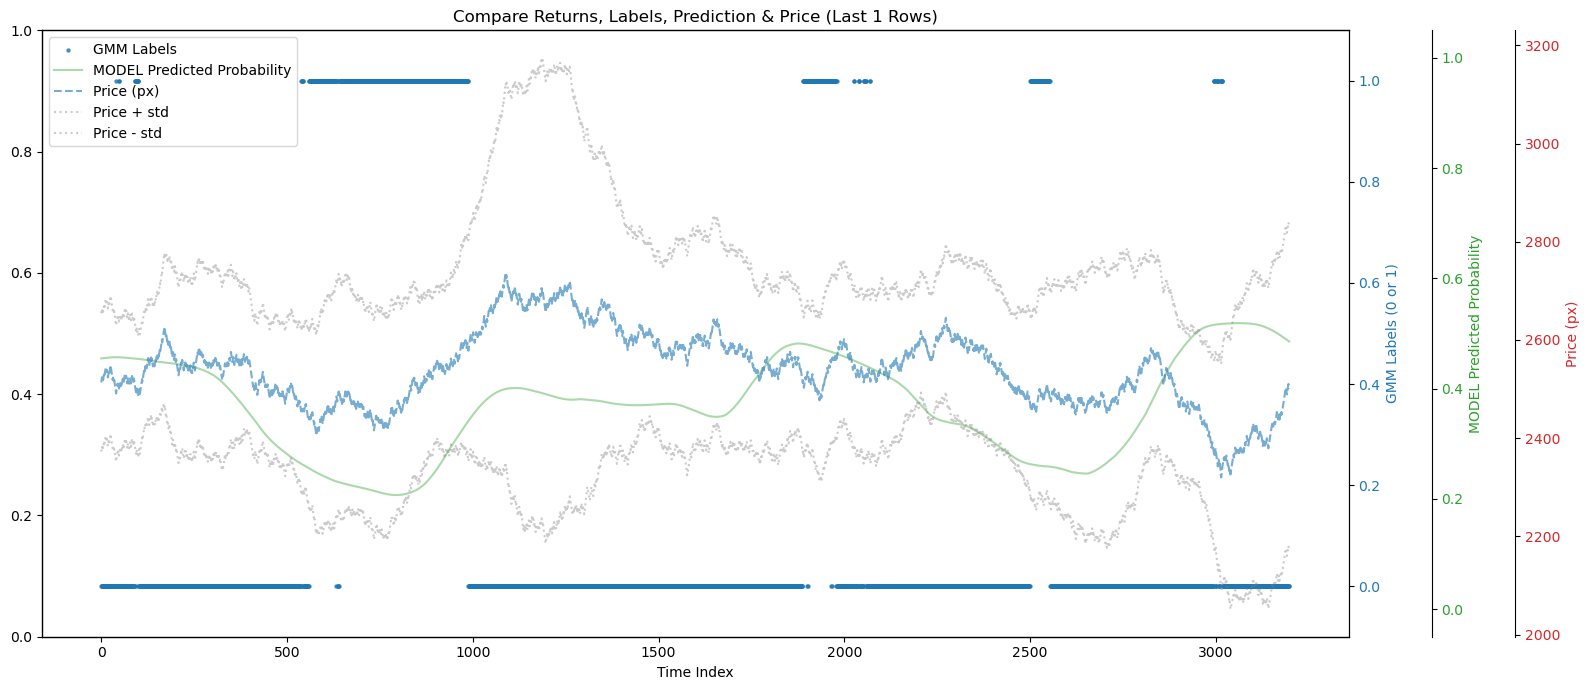

epoch 0  | loss: 0.6985  | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.1649  | val_0_balanced_accuracy: 0.48071 |  0:00:01s

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.56083


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6072
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.1728
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


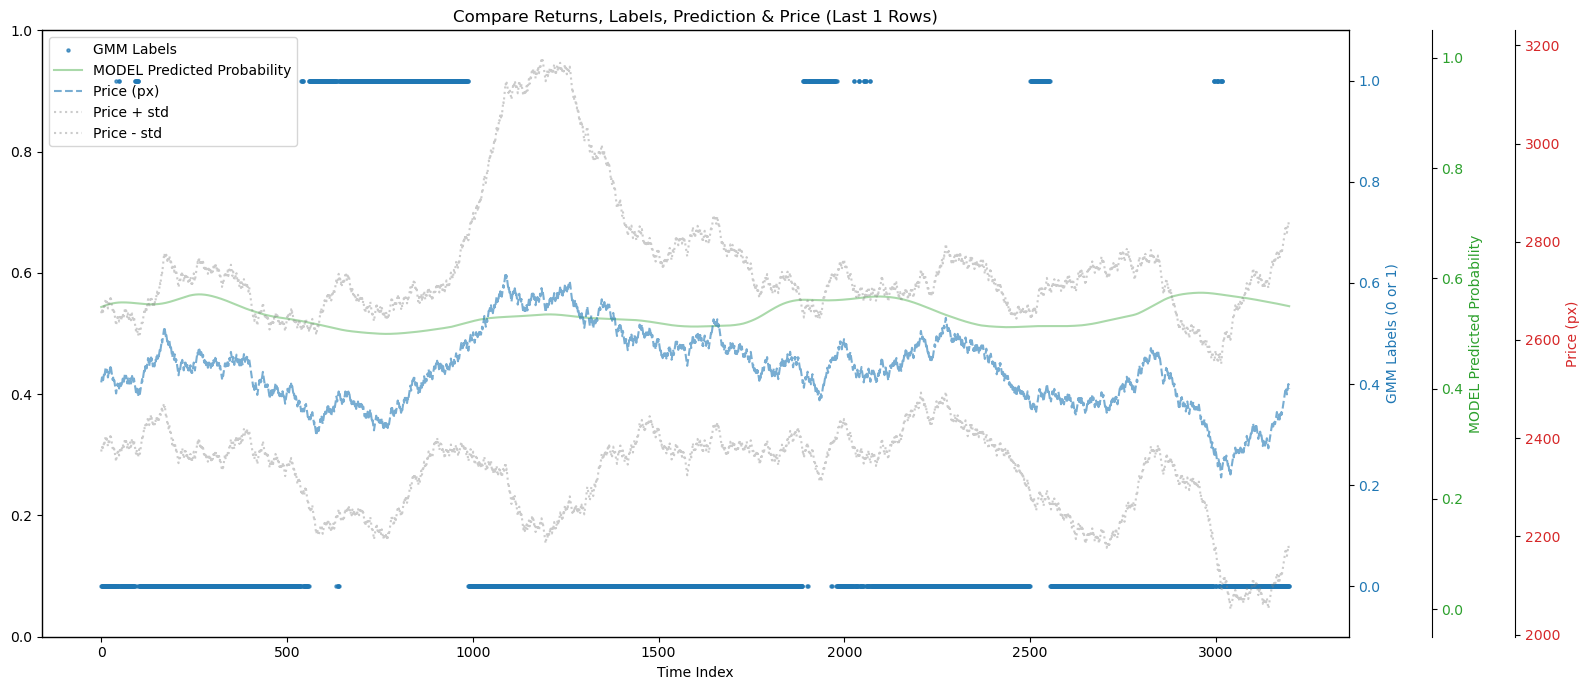

Test Week 4 Evaluation Completed
Fold 2: Train 2~4, Val 5, Test 6
Train: 2025-04-21 00:06:26.581000 to 2025-05-11 23:59:42.444000
Val: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
Test: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
GMM 分量均值: [-0.00219933  0.05647197]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.002199) => 二元标签: 0
GMM 内部标签 1 (均值: 0.056472) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [-0.02795861 -0.02769408 -0.02766241 -0.02765066 -0.0276362  -0.0316144
 -0.0316193  -0.03161499 -0.03169169 -0.03171424]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.04263049 -0.03875957 -0.03877344 -0.03873575 -0.04271909 -0.03885268
 -0.03485805 -0.03488704 -0.03883067 -0.04267707]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[0.78211905 0.78211905 0.78211905 ... 0.78211905 0.78211905 0.78211905]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21652 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.16095 | val_0_balanced_accuracy: 0.43259 |  0:00:01s
epoch 10 | loss: 0.13012 | val_0_balanced_accuracy: 0.42895 |  0:00:03s
epoch 15 | loss: 0.12981 | val_0_balanced_accuracy: 0.49091 |  0:00:05s
epoch 20 | loss: 0.11805 | val_0_balanced_accuracy: 0.44387 |  0:00:06s
epoch 25 | loss: 0.11566 | val_0_balanced_accuracy: 0.44714 |  0:00:08s
epoch 30 | loss: 0.10772 | val_0_balanced_accuracy: 0.43405 |  0:00:09s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.8591
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.7150
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


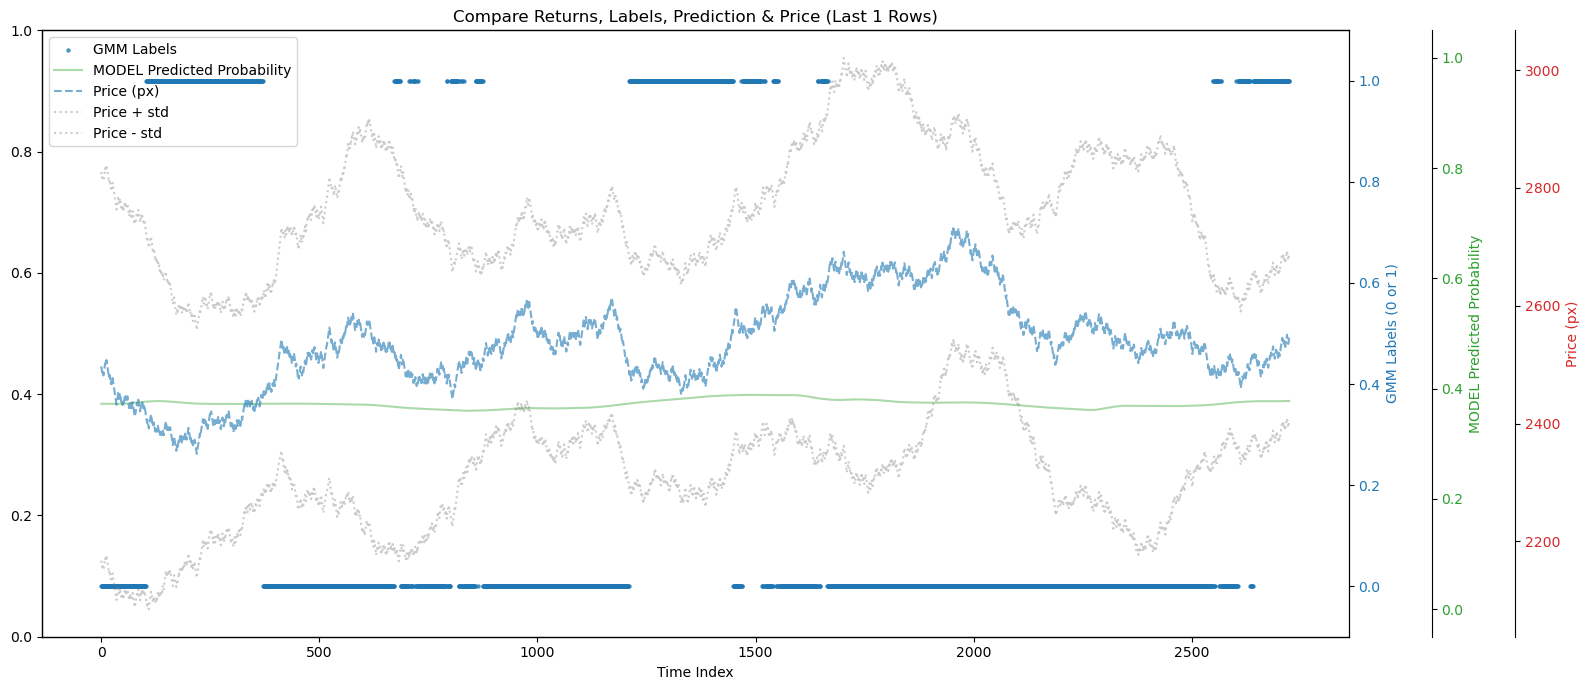

epoch 0  | loss: 0.47706 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.15812 | val_0_balanced_accuracy: 0.3279  |  0:00:01s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.1409
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.2850
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


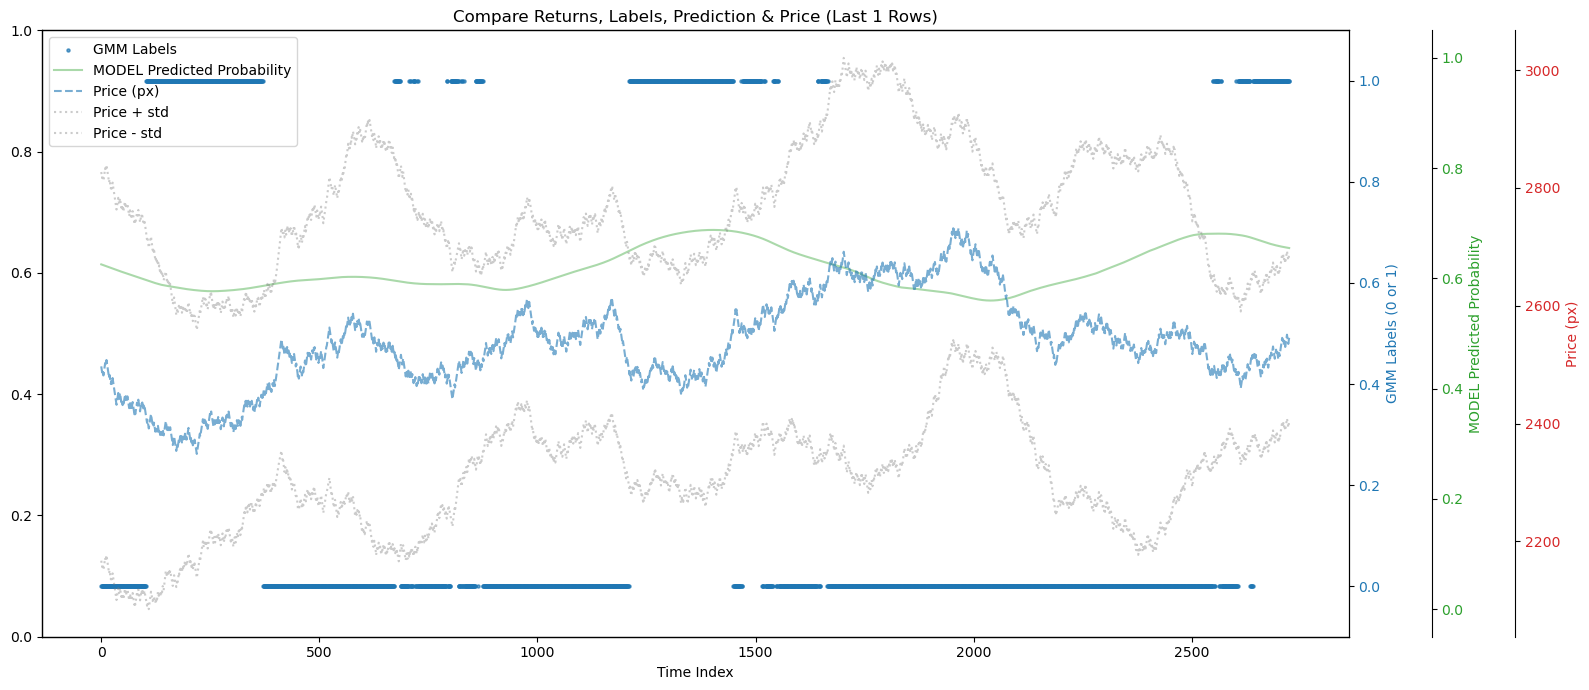

Test Week 5 Evaluation Completed
Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:07:09.088000 to 2025-05-18 23:59:05.332000
Val: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
Test: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
GMM 分量均值: [-0.01277273  0.04806279]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.012773) => 二元标签: 0
GMM 内部标签 1 (均值: 0.048063) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01367647 0.01415407 0.01553208 0.01103507 0.01164514 0.00713884
 0.01136754 0.00720152 0.00725414 0.01133329]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.04235544 0.04233543 0.03810195 0.04226843 0.04662475 0.04660136
 0.0419576  0.04139215 0.04137888 0.03719765]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.80981085 0.80981085 0.80981085 ... 0.80981085 0.80981085 0.80981085]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10096 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.1577  | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 10 | loss: 0.13234 | val_0_balanced_accuracy: 0.5     |  0:00:03s
epoch 15 | loss: 0.13139 | val_0_balanced_accuracy: 0.5     |  0:00:05s
epoch 20 | loss: 0.10657 | val_0_balanced_accuracy: 0.46131 |  0:00:07s
epoch 25 | loss: 0.10473 | val_0_balanced_accuracy: 0.45578 |  0:00:08s
epoch 30 | loss: 0.11312 | val_0_balanced_accuracy: 0.49165 |  0:00:10s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6211
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.7284
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


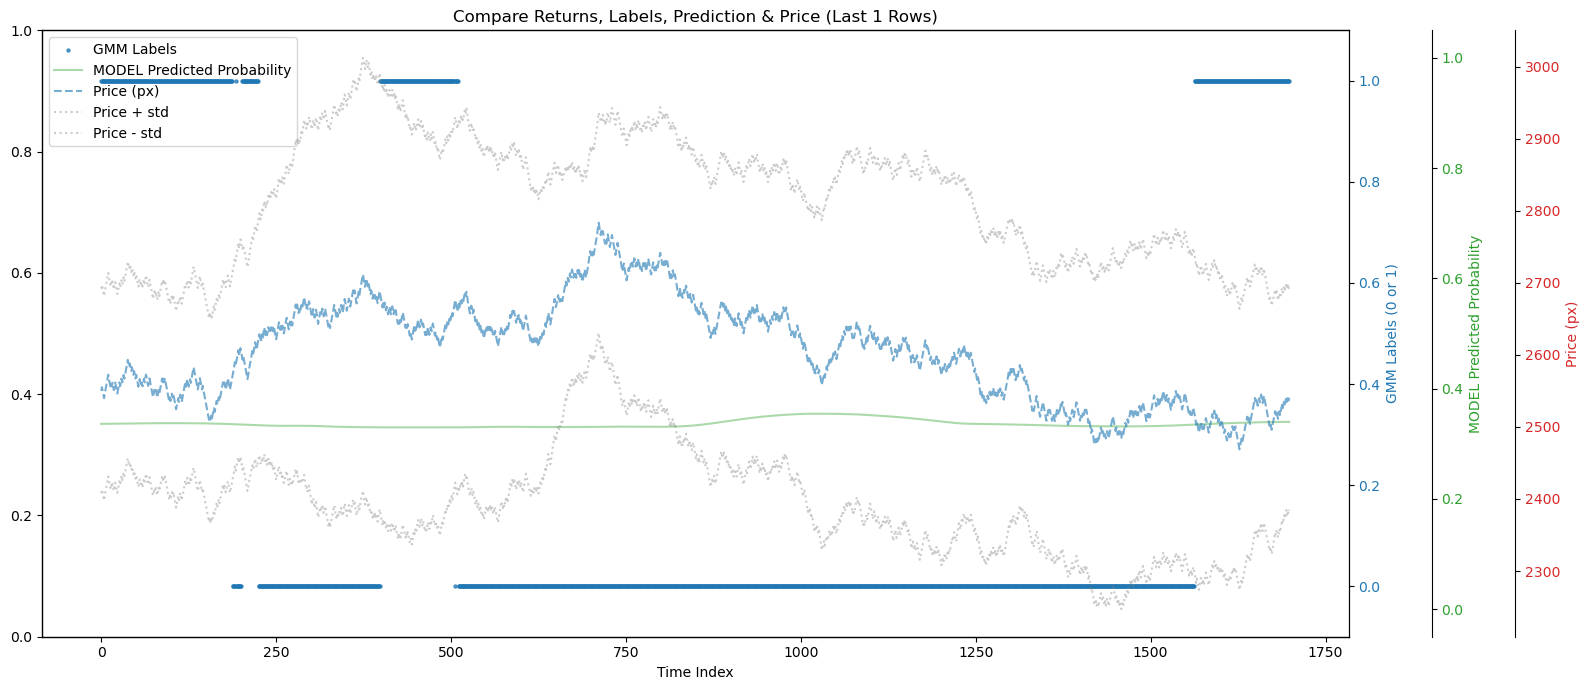

epoch 0  | loss: 0.38486 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.14202 | val_0_balanced_accuracy: 0.58195 |  0:00:02s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.61328


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6343
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6520
✅ 自信预测准确率: 1.0000 (阈值 0.2-0.8)
📈 出手率: 4.41%

🧮 自信预测混淆矩阵:
[[75]]

📝 分类报告:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        75

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


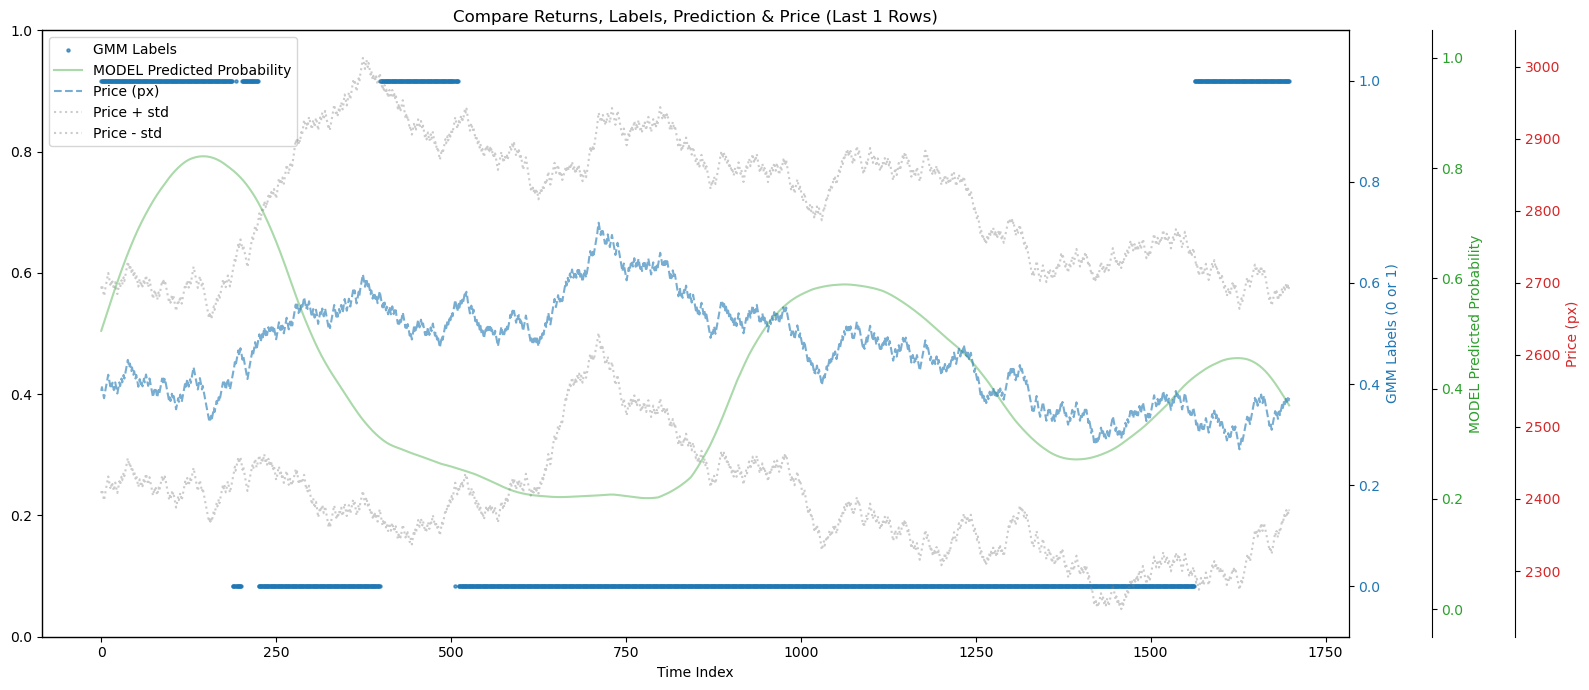

Test Week 6 Evaluation Completed
Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:13:13.815000 to 2025-05-25 23:56:39.408000
Val: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
Test: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
GMM 分量均值: [ 0.04514436 -0.01526935]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.045144) => 二元标签: 1
GMM 内部标签 1 (均值: -0.015269) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.00038088 -0.00447319 -0.004411   -0.00041488  0.00387457  0.00792024
  0.00766606  0.01178197  0.0117742   0.01177553]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.03184248 0.03176814 0.03179153 0.03173353 0.03194207 0.03194309
 0.02743144 0.02749026 0.03165541 0.03615654]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.88939828 0.88939828 0.88939828 ... 1.14201619 1.14201619 1.14201619]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91674 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.14016 | val_0_balanced_accuracy: 0.31605 |  0:00:02s
epoch 10 | loss: 0.12187 | val_0_balanced_accuracy: 0.57346 |  0:00:05s
epoch 15 | loss: 0.11124 | val_0_balanced_accuracy: 0.44617 |  0:00:07s
epoch 20 | loss: 0.09896 | val_0_balanced_accuracy: 0.45656 |  0:00:09s
epoch 25 | loss: 0.10373 | val_0_balanced_accuracy: 0.38638 |  0:00:12s
epoch 30 | loss: 0.09772 | val_0_balanced_accuracy: 0.29809 |  0:00:14s
epoch 35 | loss: 0.10084 | val_0_balanced_accuracy: 0.3479  |  0:00:17s
epoch 40 | loss: 0.09078 | val_0_balanced_accuracy: 0.20912 |  0:00:19s

Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.57346


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6802
✅ 自信预测准确率: 0.6082 (阈值 0.2-0.8)
📈 出手率: 20.11%

🧮 自信预测混淆矩阵:
[[208   0]
 [134   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       208
           1       0.00      0.00      0.00       134

    accuracy                           0.61       342
   macro avg       0.30      0.50      0.38       342
weighted avg       0.37      0.61      0.46       342


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6222
✅ 自信预测准确率: 0.8790 (阈值 0.2-0.8)
📈 出手率: 49.73%

🧮 自信预测混淆矩阵:
[[574   0]
 [ 79   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       574
           1       0.00      0.00      0.00        79

    accuracy                           0.88       653
   macro avg       0.44      0.50      0.47       653
weighted avg       0.77      0.88      0.82       653



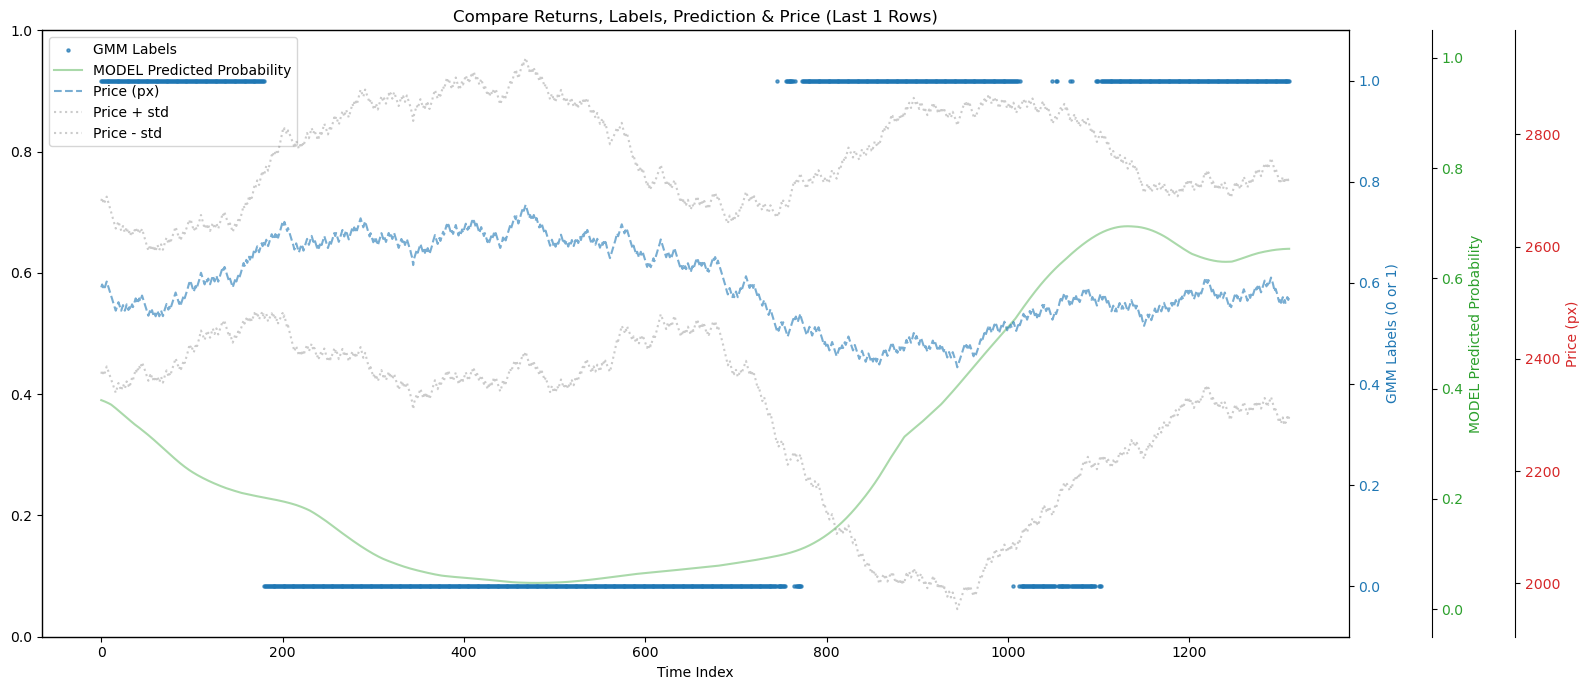

epoch 0  | loss: 0.24648 | val_0_balanced_accuracy: 0.62317 |  0:00:00s
epoch 5  | loss: 0.11973 | val_0_balanced_accuracy: 0.60495 |  0:00:03s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.68844


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7854
✅ 自信预测准确率: 0.9687 (阈值 0.2-0.8)
📈 出手率: 43.15%

🧮 自信预测混淆矩阵:
[[588   2]
 [ 21 123]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       590
           1       0.98      0.85      0.91       144

    accuracy                           0.97       734
   macro avg       0.97      0.93      0.95       734
weighted avg       0.97      0.97      0.97       734


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5545
✅ 自信预测准确率: 0.5000 (阈值 0.2-0.8)
📈 出手率: 12.64%

🧮 自信预测混淆矩阵:
[[83  0]
 [83  0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        83
           1       0.00      0.00      0.00        83

    accuracy                           0.50       166
   macro avg       0.25      0.50      0.33       166
weighted avg       0.25      0.50      0.33       166



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

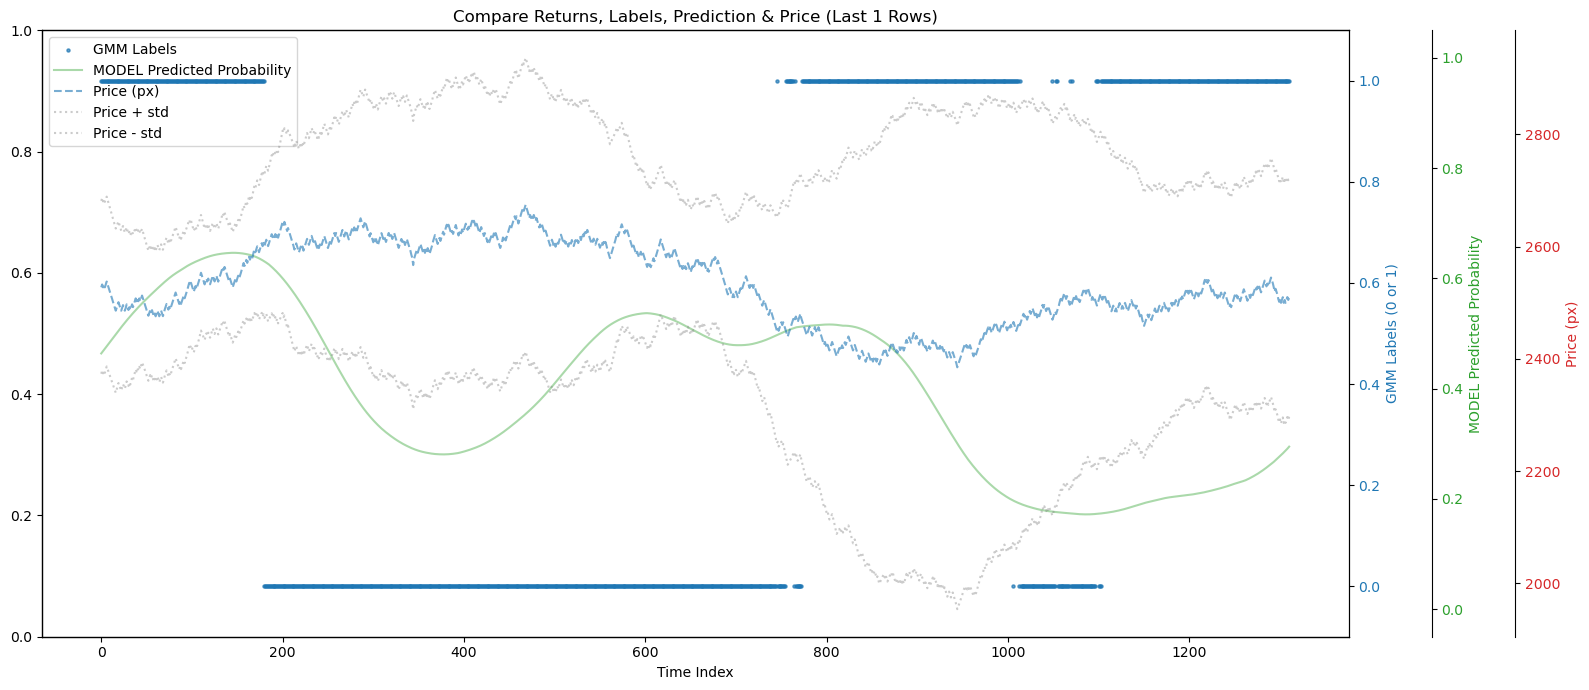

Test Week 7 Evaluation Completed
Fold 5: Train 5~7, Val 8, Test 9
Train: 2025-05-12 00:03:16.764000 to 2025-06-01 23:42:44.132000
Val: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
Test: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
GMM 分量均值: [-0.02039705  0.03196548]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.020397) => 二元标签: 0
GMM 内部标签 1 (均值: 0.031965) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01367758 0.01372577 0.01374203 0.01371019 0.013912   0.01393535
 0.01391972 0.01394685 0.01372198 0.00950708]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.1141549  0.11438494 0.11431071 0.10966392 0.11416359 0.11421926
 0.11425832 0.11423802 0.1097142  0.10974736]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[1.33807018 1.33807018 1.33807018 ... 1.33807018 1.33807018 1.33807018]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01961 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.15587 | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 10 | loss: 0.12825 | val_0_balanced_accuracy: 0.65419 |  0:00:03s
epoch 15 | loss: 0.11665 | val_0_balanced_accuracy: 0.63746 |  0:00:05s
epoch 20 | loss: 0.11626 | val_0_balanced_accuracy: 0.66405 |  0:00:06s
epoch 25 | loss: 0.11349 | val_0_balanced_accuracy: 0.66476 |  0:00:08s
epoch 30 | loss: 0.12639 | val_0_balanced_accuracy: 0.64984 |  0:00:10s
epoch 35 | loss: 0.09239 | val_0_balanced_accuracy: 0.67825 |  0:00:11s
epoch 40 | loss: 0.10515 | val_0_balanced_accuracy: 0.67044 |  0:00:13s
epoch 45 | loss: 0.09937 | val_0_balanced_accuracy: 0.63778 |  0:00:14s
epoch 50 | loss: 0.0991  | val_0_balanced_accuracy: 0.56818 |  0:00:16s
epoch 55 | loss: 0.0984  | val_0_balanced_accuracy: 0.61861 |  0:00:18s
epoch 60 | loss: 0.09001 | val_0_balanced_accuracy: 0.59375 |  0:00:19s
epoch 65 | loss: 0.09138 | val_0_balanced_accuracy: 0.48933 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6603
✅ 自信预测准确率: 0.6610 (阈值 0.2-0.8)
📈 出手率: 76.62%

🧮 自信预测混淆矩阵:
[[564   0]
 [341 101]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       564
           1       1.00      0.23      0.37       442

    accuracy                           0.66      1006
   macro avg       0.81      0.61      0.57      1006
weighted avg       0.79      0.66      0.59      1006


=== tabnet 评估结果 ===
📊 全样本准确率: 0.4847
✅ 自信预测准确率: 0.5262 (阈值 0.2-0.8)
📈 出手率: 68.16%

🧮 自信预测混淆矩阵:
[[714   0]
 [643   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       714
           1       0.00      0.00      0.00       643

    accuracy                           0.53      1357
   macro avg       0.26      0.50      0.34      1357
weighted avg       0.28      0.53      0.36      1357



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

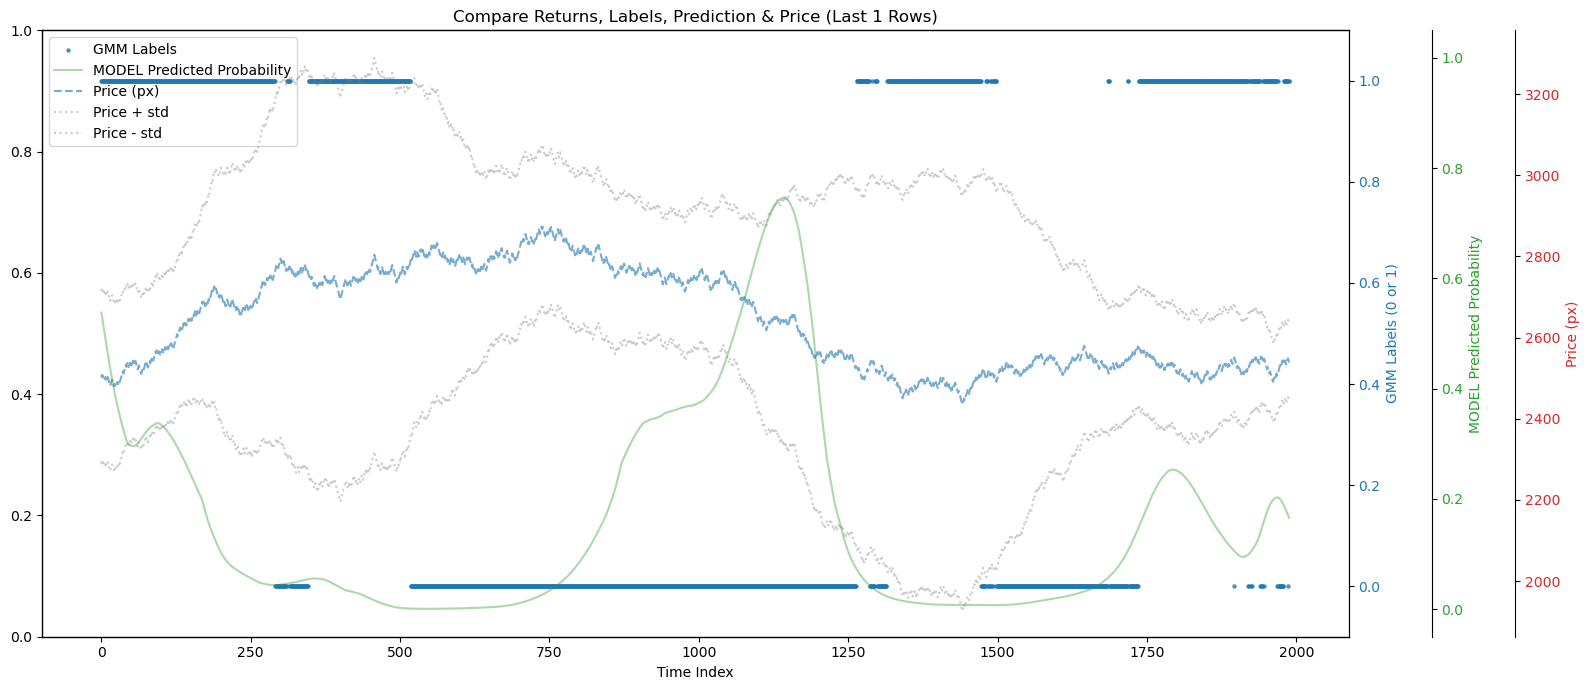

epoch 0  | loss: 0.24334 | val_0_balanced_accuracy: 0.27629 |  0:00:00s
epoch 5  | loss: 0.11185 | val_0_balanced_accuracy: 0.20314 |  0:00:01s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.28695


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3024
✅ 自信预测准确率: 0.2844 (阈值 0.2-0.8)
📈 出手率: 50.34%

🧮 自信预测混淆矩阵:
[[  0 473]
 [  0 188]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       473
           1       0.28      1.00      0.44       188

    accuracy                           0.28       661
   macro avg       0.14      0.50      0.22       661
weighted avg       0.08      0.28      0.13       661


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7177
✅ 自信预测准确率: 0.6177 (阈值 0.2-0.8)
📈 出手率: 31.14%

🧮 自信预测混淆矩阵:
[[  0 225]
 [ 12 383]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       225
           1       0.63      0.97      0.76       395

    accuracy                           0.62       620
   macro avg       0.31      0.48      0.38       620
weighted avg       0.40      0.62      0.49       620



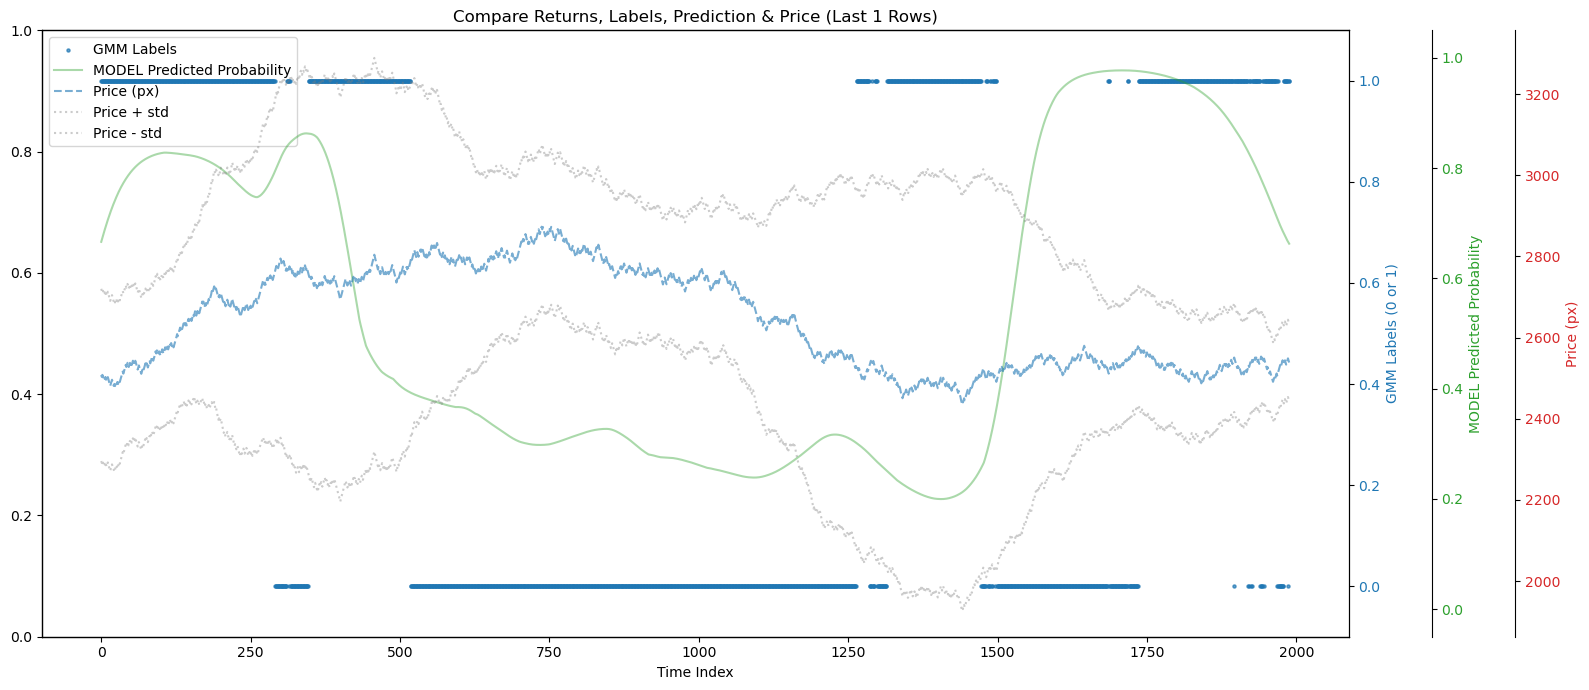

Test Week 8 Evaluation Completed
Fold 6: Train 6~8, Val 9, Test 10
Train: 2025-05-19 00:00:37.037000 to 2025-06-08 23:42:19.548000
Val: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
Test: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
GMM 分量均值: [ 0.03466408 -0.02039132]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.034664) => 二元标签: 1
GMM 内部标签 1 (均值: -0.020391) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.04263049 -0.03875957 -0.03877344 -0.03873575 -0.04271909 -0.03885268
 -0.03485805 -0.03488704 -0.03883067 -0.04267707]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.00908651 0.00926471 0.00923378 0.01347817 0.01756229 0.01332103
 0.01759101 0.01765144 0.01779659 0.0219802 ]
测试集GMM标签: [1 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 1 1 1 1 1 1 1 1 1]
[0.89519651 0.89519651 0.89519651 ... 1.13259669 1.13259669 1.13259669]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2541  | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.15877 | val_0_balanced_accuracy: 0.50911 |  0:00:01s
epoch 10 | loss: 0.12495 | val_0_balanced_accuracy: 0.52307 |  0:00:02s
epoch 15 | loss: 0.12231 | val_0_balanced_accuracy: 0.53683 |  0:00:04s
epoch 20 | loss: 0.10368 | val_0_balanced_accuracy: 0.49626 |  0:00:05s
epoch 25 | loss: 0.10038 | val_0_balanced_accuracy: 0.55564 |  0:00:06s
epoch 30 | loss: 0.10619 | val_0_balanced_accuracy: 0.55924 |  0:00:07s
epoch 35 | loss: 0.09145 | val_0_balanced_accuracy: 0.58068 |  0:00:09s
epoch 40 | loss: 0.09301 | val_0_balanced_accuracy: 0.59236 |  0:00:10s
epoch 45 | loss: 0.09219 | val_0_balanced_accuracy: 0.55706 |  0:00:11s
epoch 50 | loss: 0.08364 | val_0_balanced_accuracy: 0.55611 |  0:00:12s
epoch 55 | loss: 0.09236 | val_0_balanced_accuracy: 0.53269 |  0:00:14s
epoch 60 | loss: 0.09605 | val_0_balanced_accuracy: 0.63852 |  0:00:15s
epoch 65 | loss: 0.08974 | val_0_balanced_accuracy: 0.57671 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6690
✅ 自信预测准确率: 0.6991 (阈值 0.2-0.8)
📈 出手率: 67.10%

🧮 自信预测混淆矩阵:
[[736  47]
 [355 198]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.67      0.94      0.79       783
           1       0.81      0.36      0.50       553

    accuracy                           0.70      1336
   macro avg       0.74      0.65      0.64      1336
weighted avg       0.73      0.70      0.67      1336


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6414
✅ 自信预测准确率: 0.6408 (阈值 0.2-0.8)
📈 出手率: 71.81%

🧮 自信预测混淆矩阵:
[[1108  345]
 [ 280    7]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1453
           1       0.02      0.02      0.02       287

    accuracy                           0.64      1740
   macro avg       0.41      0.39      0.40      1740
weighted avg       0.67      0.64      0.65      1740



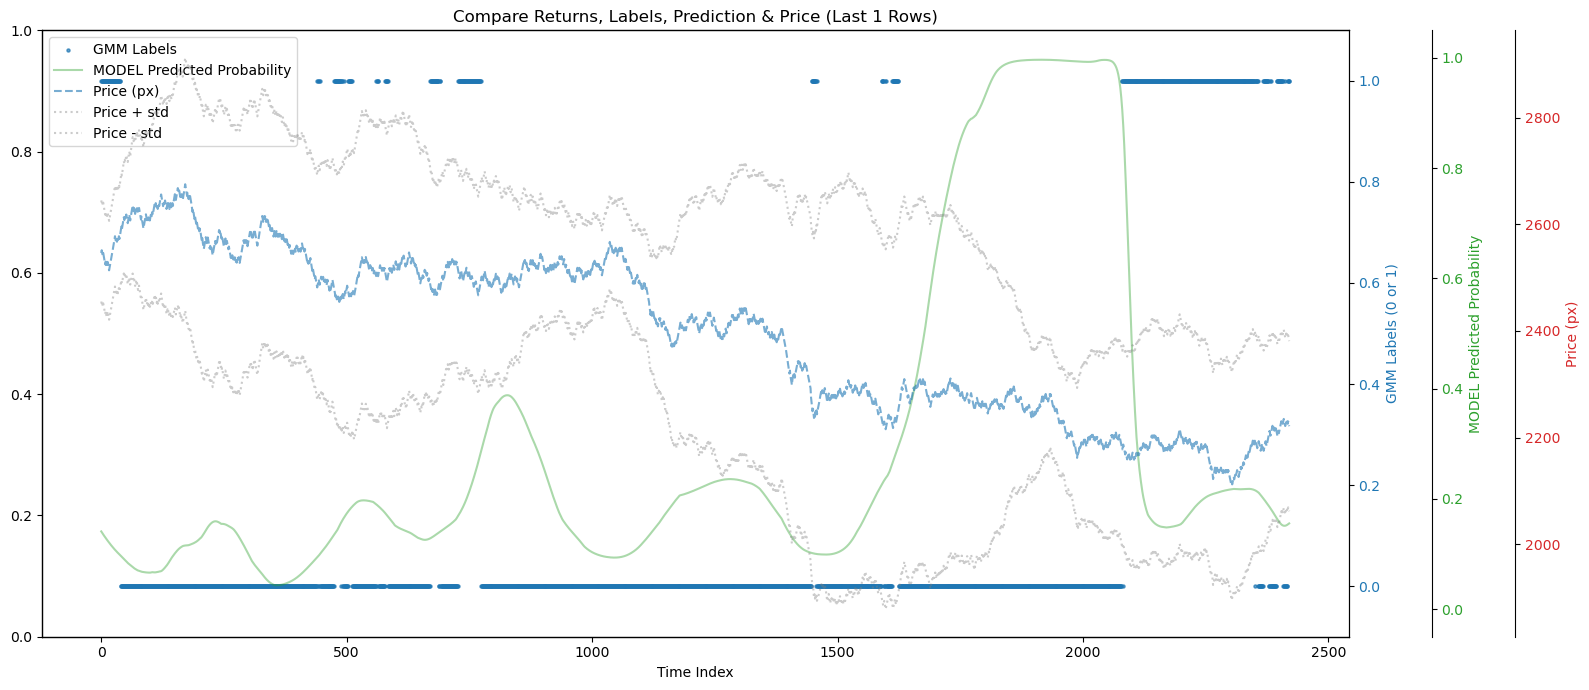

epoch 0  | loss: 0.28502 | val_0_balanced_accuracy: 0.69925 |  0:00:00s
epoch 5  | loss: 0.11515 | val_0_balanced_accuracy: 0.68448 |  0:00:01s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.71057


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7228
✅ 自信预测准确率: 0.5102 (阈值 0.2-0.8)
📈 出手率: 41.74%

🧮 自信预测混淆矩阵:
[[161 139]
 [268 263]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.38      0.54      0.44       300
           1       0.65      0.50      0.56       531

    accuracy                           0.51       831
   macro avg       0.51      0.52      0.50       831
weighted avg       0.55      0.51      0.52       831


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6909
✅ 自信预测准确率: 0.8326 (阈值 0.2-0.8)
📈 出手率: 29.84%

🧮 自信预测混淆矩阵:
[[340 100]
 [ 21 262]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       440
           1       0.72      0.93      0.81       283

    accuracy                           0.83       723
   macro avg       0.83      0.85      0.83       723
weighted avg       0.86      0.83      0.83       723



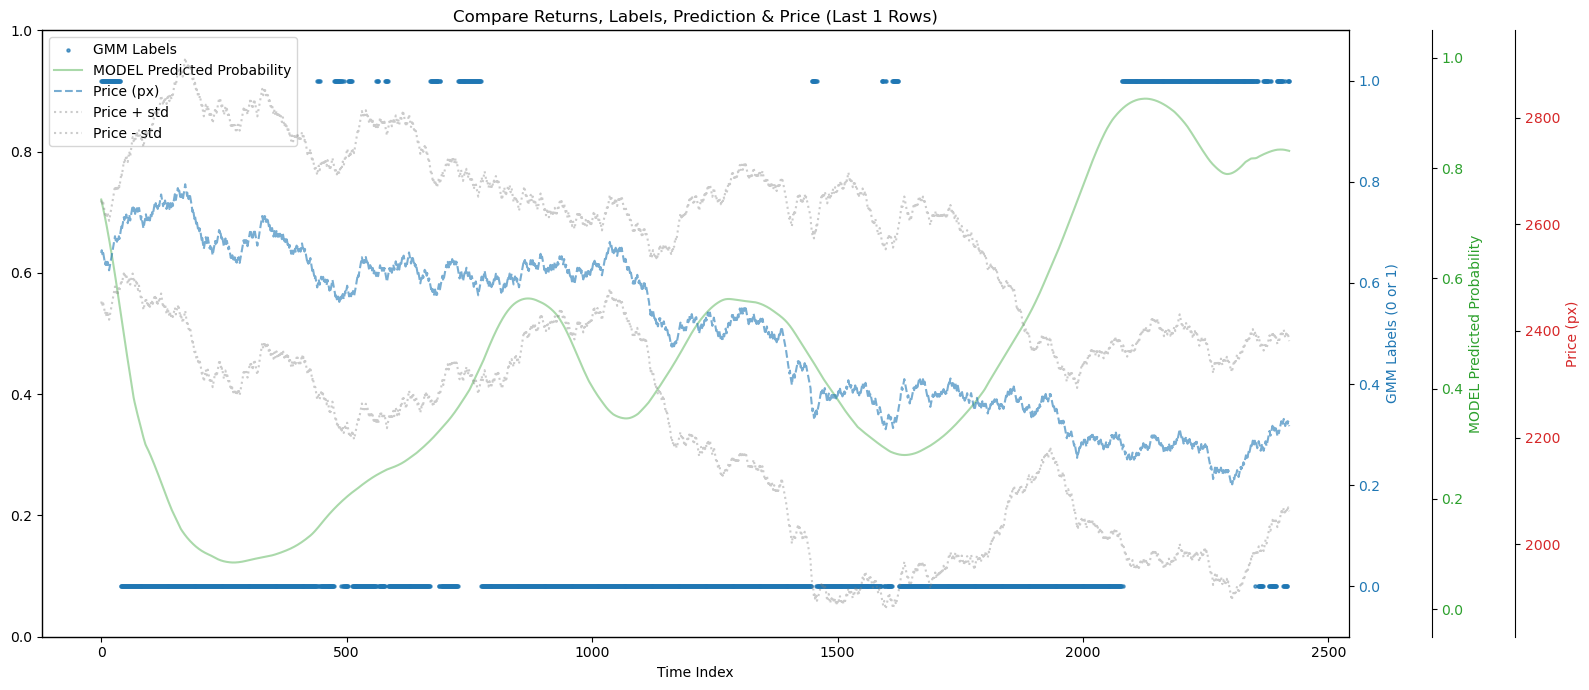

Test Week 9 Evaluation Completed
Fold 7: Train 7~9, Val 10, Test 11
Train: 2025-05-26 00:03:04.226000 to 2025-06-15 23:19:26.719000
Val: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
Test: 2025-06-23 00:01:33.194000 to 2025-06-26 03:06:39.215000
GMM 分量均值: [ 0.02273933 -0.03533961]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.022739) => 二元标签: 1
GMM 内部标签 1 (均值: -0.035340) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.04235544 0.04233543 0.03810195 0.04226843 0.04662475 0.04660136
 0.0419576  0.04139215 0.04137888 0.03719765]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.01943911 0.01946736 0.01533537 0.01540306 0.01971914 0.02383381
 0.01961092 0.01959319 0.01968349 0.01545873]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.7379829 0.7379829 0.7379829 ... 0.7379829 0.7379829 0.7379829]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07761 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.1292  | val_0_balanced_accuracy: 0.5     |  0:00:01s
epoch 10 | loss: 0.10495 | val_0_balanced_accuracy: 0.34546 |  0:00:02s
epoch 15 | loss: 0.10909 | val_0_balanced_accuracy: 0.31282 |  0:00:03s
epoch 20 | loss: 0.11165 | val_0_balanced_accuracy: 0.3751  |  0:00:04s
epoch 25 | loss: 0.10123 | val_0_balanced_accuracy: 0.41448 |  0:00:05s
epoch 30 | loss: 0.09946 | val_0_balanced_accuracy: 0.41598 |  0:00:06s
epoch 35 | loss: 0.09106 | val_0_balanced_accuracy: 0.46176 |  0:00:07s

Early stopping occurred at epoch 37 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.53304


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5617
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.0034
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


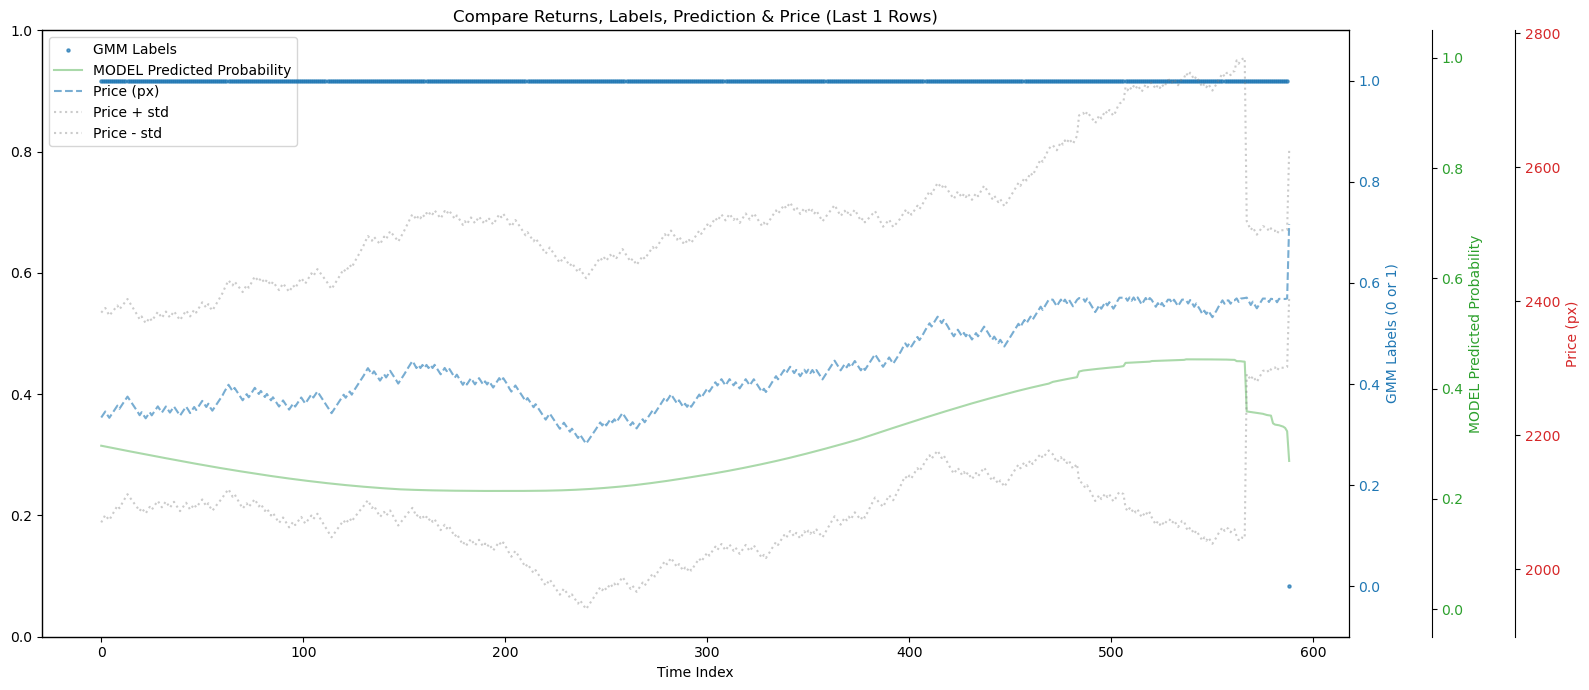

epoch 0  | loss: 0.35143 | val_0_balanced_accuracy: 0.43082 |  0:00:00s
epoch 5  | loss: 0.10973 | val_0_balanced_accuracy: 0.5     |  0:00:01s

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4593
✅ 自信预测准确率: 0.4422 (阈值 0.2-0.8)
📈 出手率: 64.59%

🧮 自信预测混淆矩阵:
[[  0 873]
 [  0 692]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       873
           1       0.44      1.00      0.61       692

    accuracy                           0.44      1565
   macro avg       0.22      0.50      0.31      1565
weighted avg       0.20      0.44      0.27      1565


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8629
✅ 自信预测准确率: 0.9817 (阈值 0.2-0.8)
📈 出手率: 18.44%

🧮 自信预测混淆矩阵:
[[  0   2]
 [  0 107]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.98      1.00      0.99       107

    accuracy                           0.98       109
   macro avg       0.49      0.50      0.50       109
weighted avg       0.96      0.98      0.97       109



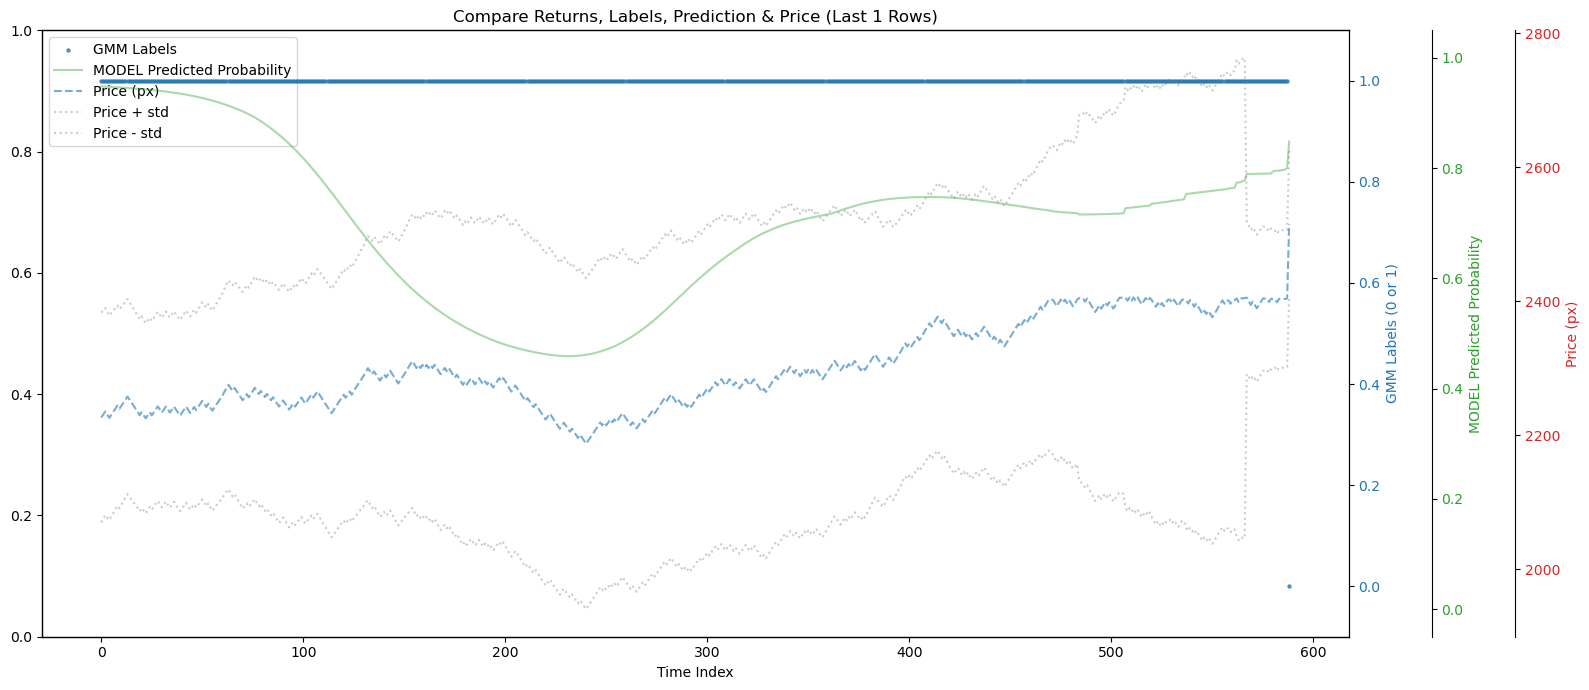

Test Week 10 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp   symbol  true_label  predicted_prob       px  rolling_std
0  1746403993815  BTCUSDT           0        0.369084  1811.61    15.320063
1  1746404934654  BTCUSDT           0        0.369081  1815.26    15.255311
2  1746407176678  BTCUSDT           0        0.369077  1811.38    15.177577
3  1746407938227  BTCUSDT           0        0.369073  1807.75    15.130294
4  1746408487452  BTCUSDT           0        0.369069  1804.07    15.077517
Total rows collected: 17331
整体训练时间范围：2025-04-08 16:23:02.479000 到 2025-06-26 03:06:39.215000


In [14]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{step}"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("zd_scaled") 
        and (col.startswith("z_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)

# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = test_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    y_train, y_val, y_test, gmm_model = gmm_label_binarize(y_train, y_val, y_test, verbose=True)


    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # if lgb_model == None:
    #     lgb_model = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbose=-1)
    #     early_stopping_callback = lgb.early_stopping(
    #         stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #         verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    #     )
    #     lgb_model.fit(
    #         X_train, y_train,
    #         sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #         eval_set=[(X_val, y_val)],
    #         eval_metric='acc',
    #         # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    #     )

    # else:
    #     lgb_model.fit(
    #         X_train, y_train,
    #         sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #         eval_set=[(X_val, y_val)],
    #         eval_metric='acc',
    #         # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    #     )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    params = {
        # 模型结构参数
        "n_d": 16,                      # 决策输出维度
        "n_a": 16,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "entmax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 1e-2},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 5,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 300,
        "patience": 30,
        "batch_size": 1024,
        "virtual_batch_size": 256,
    }

    inc_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 50,
        "patience": 5,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    print(sample_weights)
    # TabNet 训练
    tabnet = TabNetClassifier(**params)
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        weights=sample_weights,
        **init_fit_params,
    )

    # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    tabnet_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )

    plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(**params)
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **init_fit_params,
        )

        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **inc_fit_params,
        )

        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")
overall_start = str(overall_start)
overall_end = str(overall_end)

In [15]:
print(tab_inc.classes_)  # 输出通常是 array([0, 1])


[0 1]


In [16]:
# import pickle

# pkl_path = "./saved_models/tabnet_inc/model_2025-06-22_19-51/auxiliary.pkl"

# with open(pkl_path, "rb") as f:
#     data = pickle.load(f)

# print(data)


In [17]:
print(len(X_test.columns))

1495


In [18]:
explain_matrix, masks = tab_inc.explain(X_test.values)


Top 20 Features by Importance:

z_sum_sz_rol_mean_500_zd_scaled          Importance: 0.205986
z_factor_orderflow_sz_momentum_zd_scaled Importance: 0.187036
z_px_pct_rol_sum_40_minus_z_oi_di_zd_scaled Importance: 0.147596
z_oi_px_diff_500_lag_50_zd_scaled        Importance: 0.121480
z_factor_px_oi_force_lag_100_zd_scaled   Importance: 0.118467
z_ask_px_gap_rol_mean_500_minus_z_factor_px_oi_force_zd_scaled Importance: 0.111676
z_bs_ratio_rol_mean_500_minus_z_oi_di_long_term_zd_scaled Importance: 0.111650
z_factor_sentiment_net_momentum_ratio_10_zd_scaled Importance: 0.111184
z_oi_down_divergence_long_term_minus_z_oi_down_divergence_short_term_zd_scaled Importance: 0.085688
z_px_pct_rol_sum_20_minus_z_lob_ratio_rol_mean_500_zd_scaled Importance: 0.083754
z_oi_di_minus_z_factor_oi_trend_slope_zd_scaled Importance: 0.082884
z_factor_short_term_oi_volatility_minus_z_lob_sz_imba_rol_mean_500_zd_scaled Importance: 0.078841
z_bs_ratio_rol_mean_500_minus_z_sum_sz_px_pct_rol_sum_500_zd_scaled Imp

C:\Users\Grayman\AppData\Local\Temp\ipykernel_12392\2508309008.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


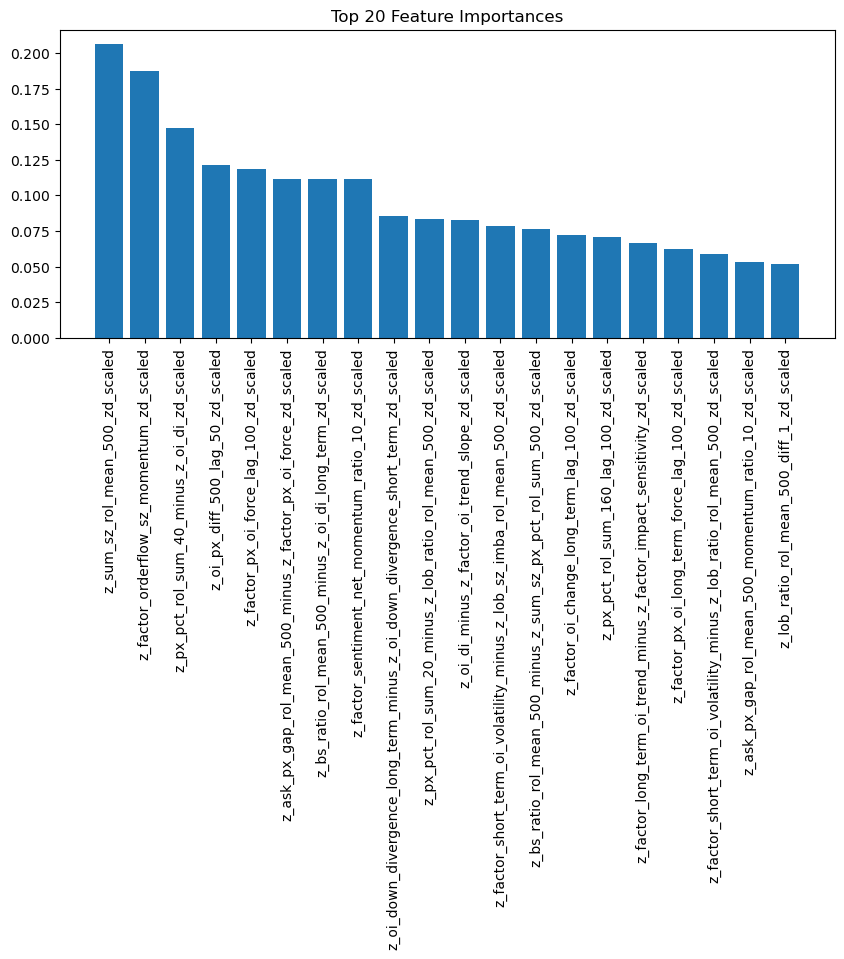

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [  18   40   49   62   76  219  234  242  271  279  284  323  377  417
  426  501  641  678  728  754  796  799  849  864  879  970 1041 1049
 1064 1079 1141 1163 1167 1235 1259 1293 1317 1325 1342 1382 1385 1439]
对应的权重: [1.94080900e-02 7.77919311e-03 2.30644760e-03 7.49298930e-02
 1.97940860e-02 4.88440390e-04 2.18950920e-02 8.69237911e-03
 1.47877276e-04 2.79265977e-02 9.53495502e-04 3.96684743e-02
 5.14684841e-02 7.23170713e-02 1.95620805e-02 7.90447649e-03
 2.43039373e-02 5.53879440e-02 2.09541572e-03 1.85450795e-03
 5.53922000e-05 8.33330527e-02 6.17887154e-02 2.86838934e-02
 1.73012353e-02 9.94007041e-06 5.33919735e-03 1.31470218e-01
 1.21459318e-03 4.15134011e-03 9.11997085e-06 9.42038186e-03
 5.78307780e-04 3.51956226e-02 9.79327888e-05 2.83380244e-02
 3.52000967e-02 7.58583471e-02 1.52048201e-03 9.18006897e-03
 7.36509566e-04 1.16343256e-02]
特征: z_sum_sz_rol_mean_500_zd_scaled, 权重: 0.0194
特征: z_factor_orderflow_sz_momentum_zd_scaled, 权重: 0.0078
特征: z_factor_oi_change

In [21]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [22]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共42个非零特征）:
  特征: z_ask_px_gap_rol_mean_500_minus_z_factor_px_oi_force_zd_scaled 权重: 0.1315
  特征: z_px_pct_rol_sum_20_minus_z_lob_ratio_rol_mean_500_zd_scaled 权重: 0.0833
  特征: z_oi_down_divergence_long_term_minus_z_oi_down_divergence_short_term_zd_scaled 权重: 0.0759
  特征: z_factor_oi_change_long_term_lag_100_zd_scaled 权重: 0.0749
  特征: z_factor_oi_breakout_signal_momentum_ratio_10_zd_scaled 权重: 0.0723
  特征: z_px_pct_rol_sum_40_minus_z_oi_di_zd_scaled 权重: 0.0618
  特征: z_factor_long_term_oi_trend_minus_z_px_pct_rol_sum_40_zd_scaled 权重: 0.0554
  特征: z_factor_px_oi_long_term_force_lag_100_zd_scaled 权重: 0.0515
  特征: z_oi_di_lag_100_zd_scaled      权重: 0.0397
  特征: z_oi_up_divergence_long_term_minus_z_factor_impact_sensitivity_zd_scaled 权重: 0.0352
  特征: z_lob_sz_imba_rol_mean_500_minus_z_factor_impact_sensitivity_zd_scaled 权重: 0.0352
  特征: z_px_pct_rol_sum_40_minus_z_factor_oi_momentum_long_term_punch_zd_scaled 权重: 0.0287
  特征: z_oi_down_divergence_minus_z_taker_px_pct_diff_zd_scaled 权

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(masks, feature_names, sample_idx=0):
    """
    可视化 TabNet attention mask 热力图。
    """
    steps = sorted(masks.keys())
    mask_matrix = np.vstack([masks[step][sample_idx] for step in steps])

    plt.figure(figsize=(min(20, len(feature_names) * 0.3), len(steps)))
    sns.heatmap(mask_matrix, cmap="viridis", xticklabels=feature_names, yticklabels=[f"Step {s}" for s in steps])
    plt.title(f"TabNet Attention Heatmap for Sample {sample_idx}")
    plt.xlabel("Feature")
    plt.ylabel("Decision Step")
    plt.tight_layout()
    plt.show()


In [24]:
# plot_attention_heatmap(masks, X_train.columns, sample_idx=0)



=== model 评估结果 ===
📊 全样本准确率: 0.4723
✅ 自信预测准确率: 0.7383 (阈值 0.2-0.8)
📈 出手率: 9.77%

🧮 自信预测混淆矩阵:
[[423 327]
 [116 827]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.78      0.56      0.66       750
           1       0.72      0.88      0.79       943

    accuracy                           0.74      1693
   macro avg       0.75      0.72      0.72      1693
weighted avg       0.75      0.74      0.73      1693



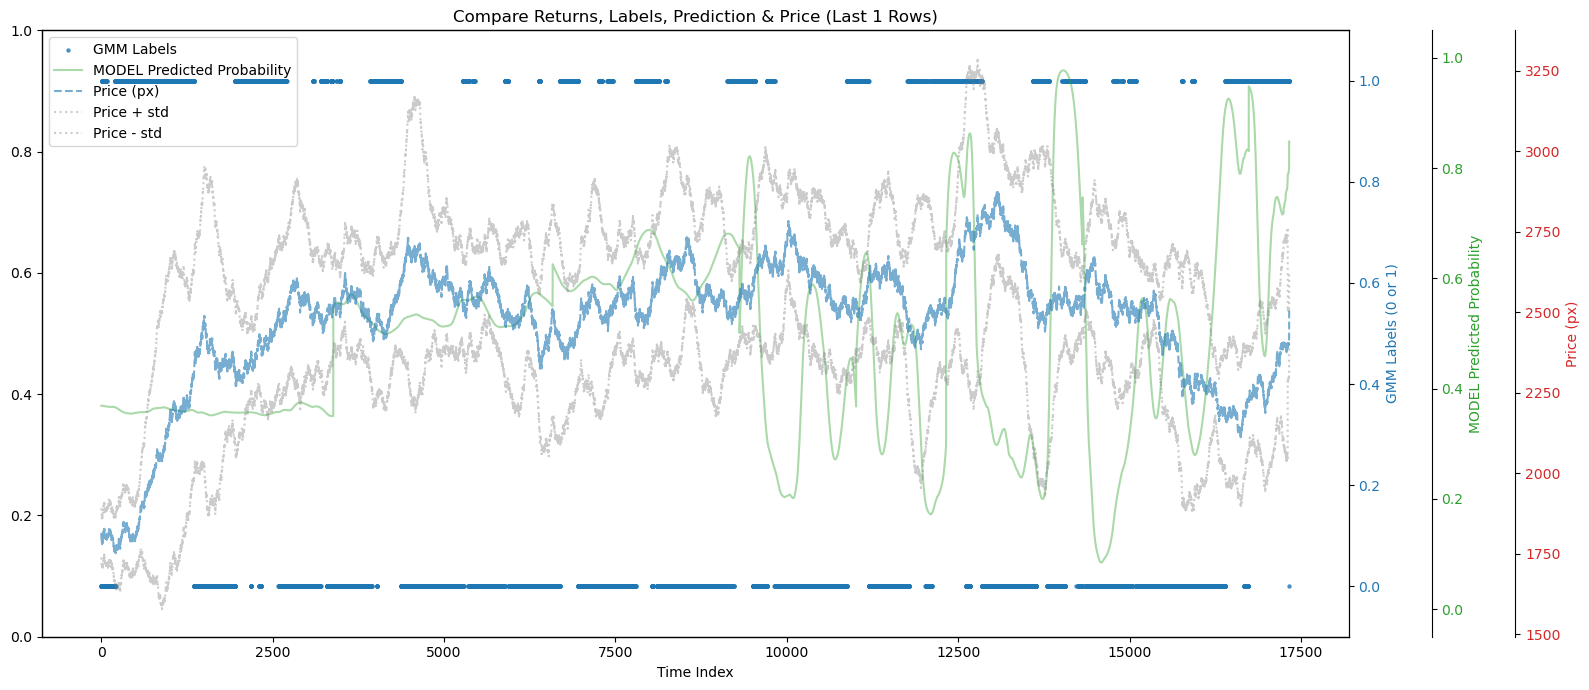

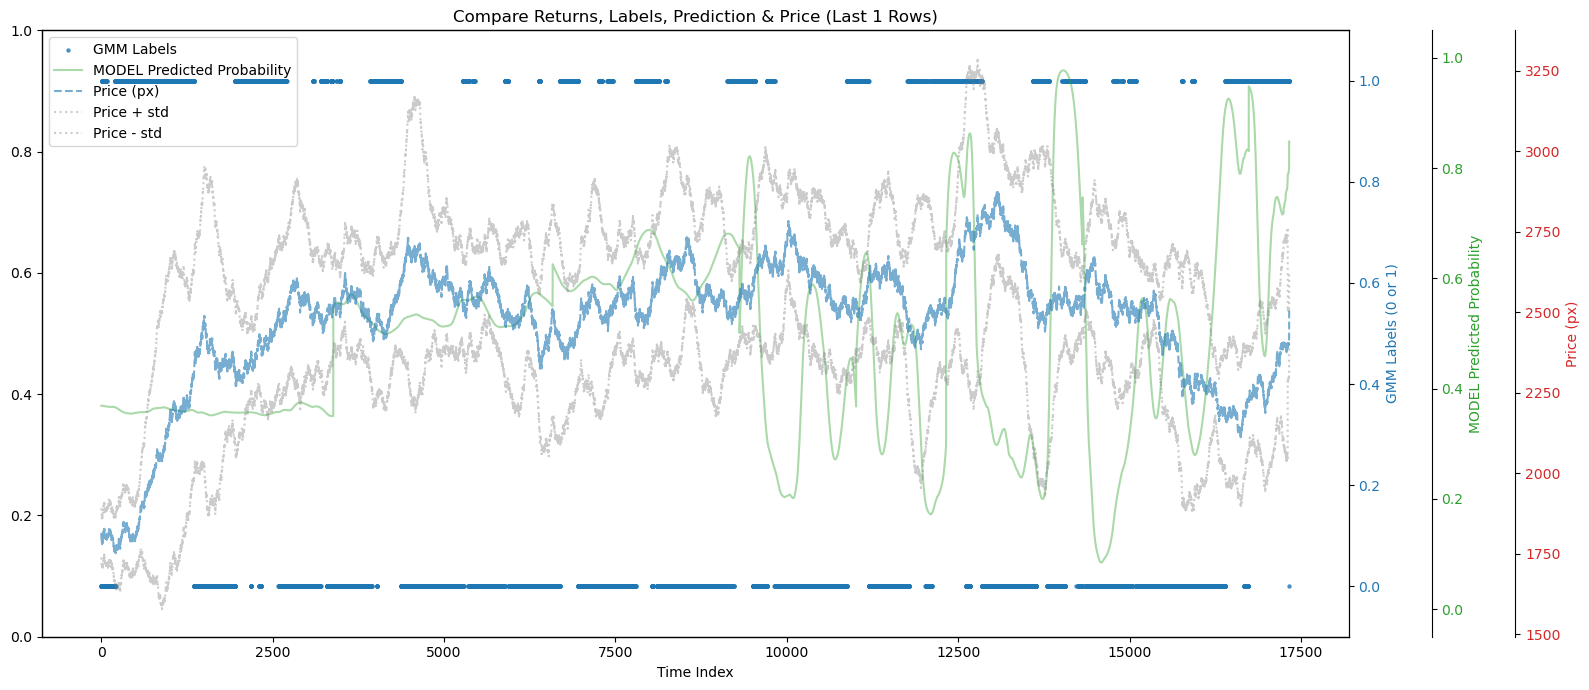

timestamp   symbol  true_label  predicted_prob       px  \
0      1746403993815  BTCUSDT           0        0.369084  1811.61   
1      1746404934654  BTCUSDT           0        0.369081  1815.26   
2      1746407176678  BTCUSDT           0        0.369077  1811.38   
3      1746407938227  BTCUSDT           0        0.369073  1807.75   
4      1746408487452  BTCUSDT           0        0.369069  1804.07   
...              ...      ...         ...             ...      ...   
17326  1750866430301  BTCUSDT           1        0.796757  2403.30   
17327  1750866927415  BTCUSDT           1        0.797691  2403.26   
17328  1750870020737  BTCUSDT           1        0.800067  2403.99   
17329  1750907076016  BTCUSDT           0        0.848359  2515.03   
17330  1750907199215  BTCUSDT           0        0.848803  2509.99   

       rolling_std  predicted_prob_rolling_mean  
0        15.320063                     0.369084  
1        15.255311                     0.369081  
2        15.177577                     0.369077  
3        15.130294                     0.369073  
4        15.077517                     0.369069  
...            ...                          ...  
17326    20.536249                     0.796757  
17327    20.590217                     0.797691  
17328    20.457976                     0.800067  
17329    21.880942                     0.848359  
17330    22.024696                     0.848803  

[17331 rows x 7 columns]

In [25]:
rolling_window_size = 1

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df["true_label"],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.2,
    upper_thresh=0.8,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df["true_label"],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df["true_label"], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df

In [26]:
from scipy.stats import spearmanr

signal_col = 'predicted_prob'
return_col = "true_label"

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"100步 Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


100步 Rank IC: 0.0920, p-value: 6.882e-34


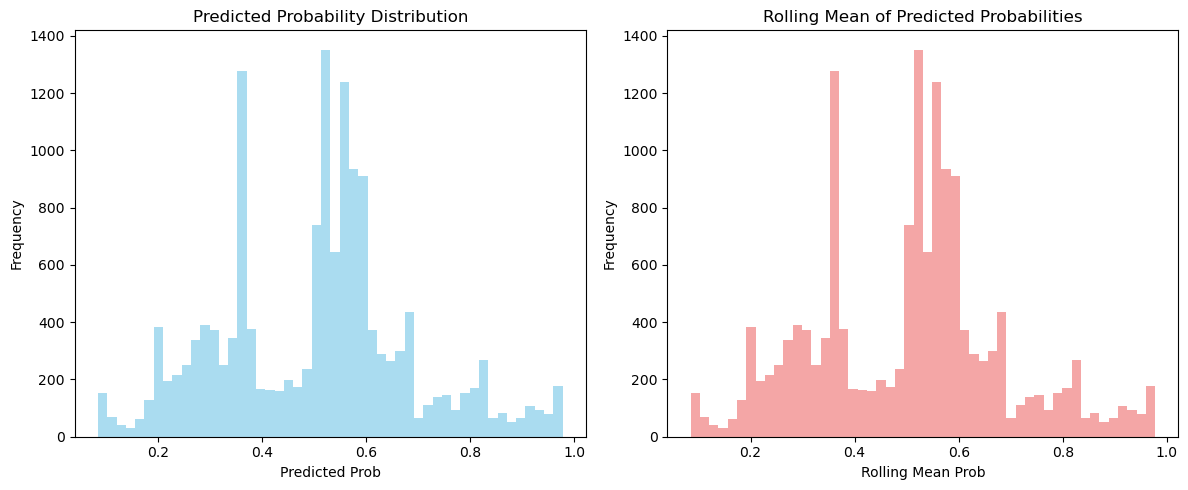

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_prob'][2000:], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][2000:], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 122202.29
Total Return: 22.20%
Total Realized PnL: 27048.87
年化收益 (近似): 307.21%
Maximum Drawdown: -5.54%
Sharpe Ratio (Risk-Free Rate = 0): 1274.46
Number of Trades: 24
Win Rate: 58.33%


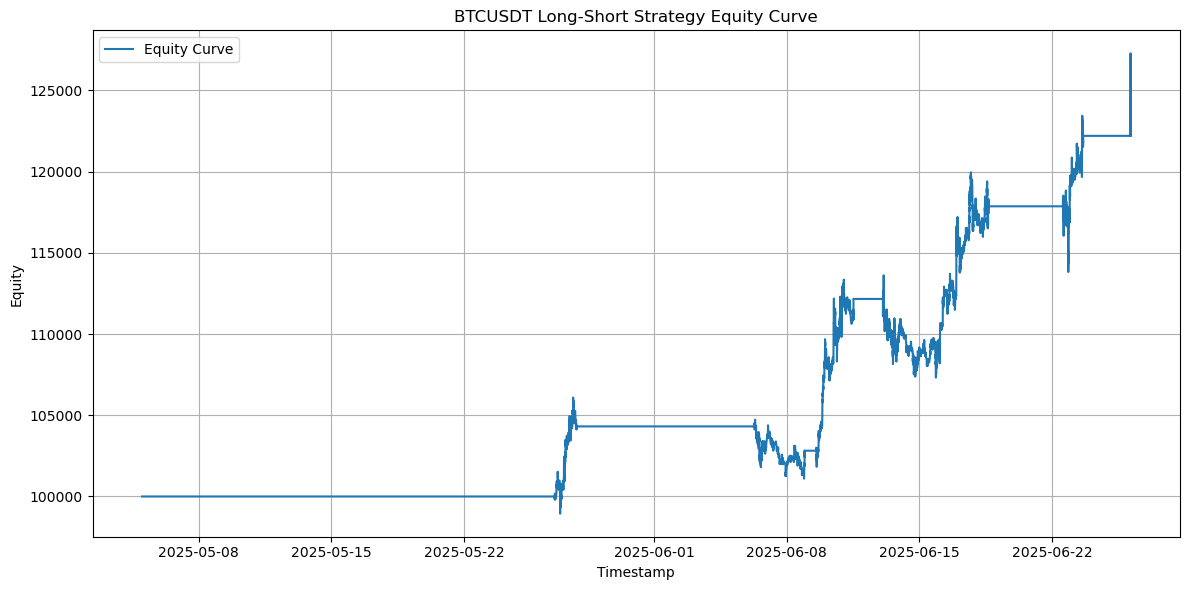

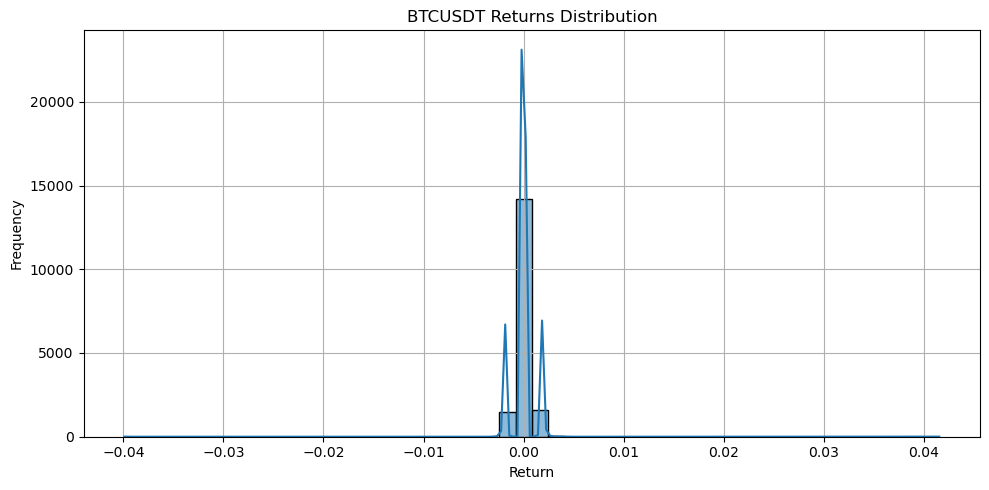

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.000005 # Commission ratio (e.0.05%)
slippage_ratio = 0.00001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.8 # Predicted probability above this to go long (buy)
short_threshold = 0.2 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

a = 0
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        elif a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        elif a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 101926.86
Total Return: 1.93%
Total Realized PnL: 1926.86
年化收益 (近似): 14.30%
Maximum Drawdown: -3.23%
Sharpe Ratio (Risk-Free Rate = 0): 190.62
Number of Trades: 2
Win Rate: 100.00%


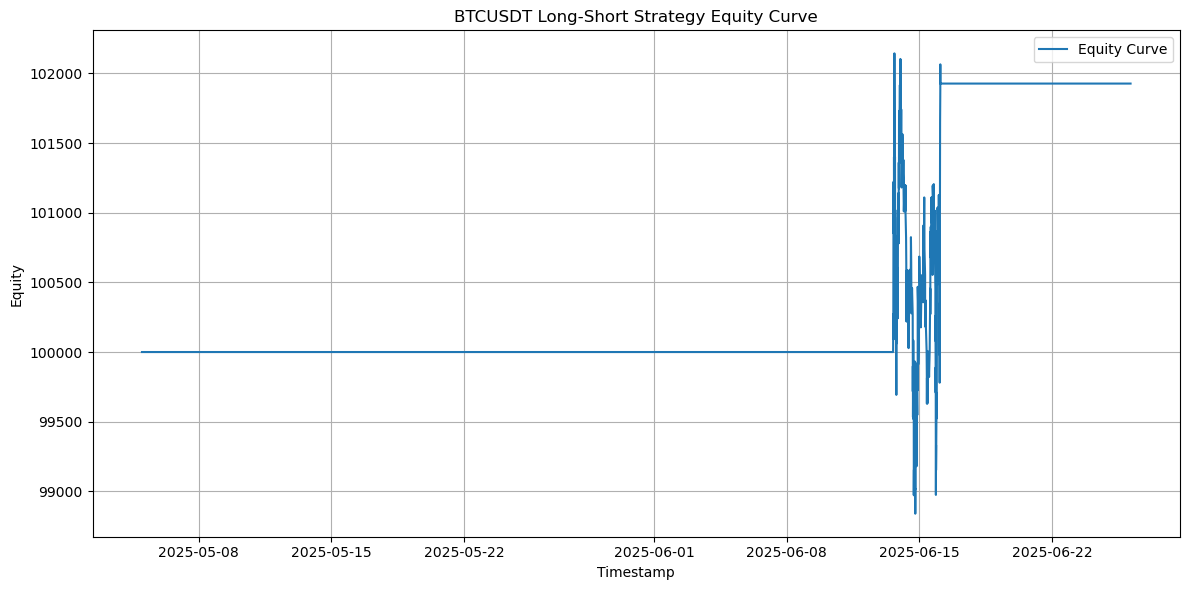

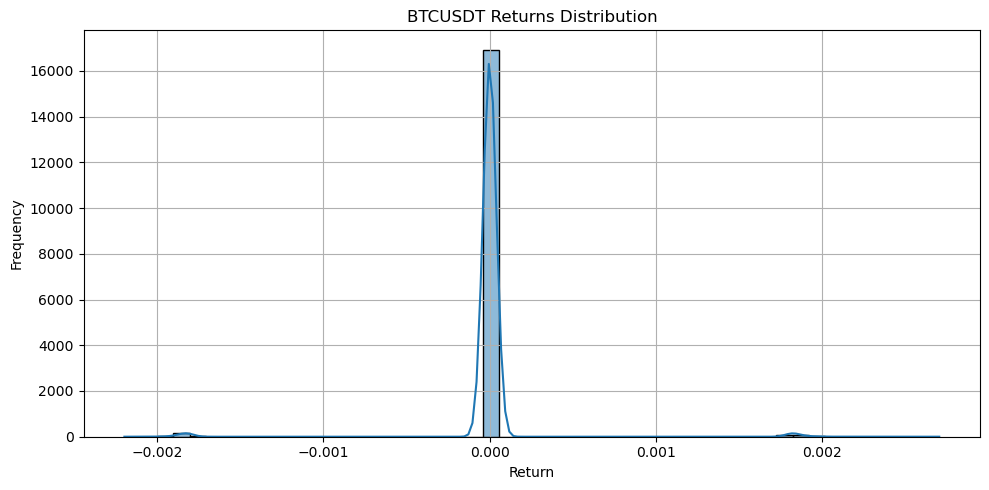

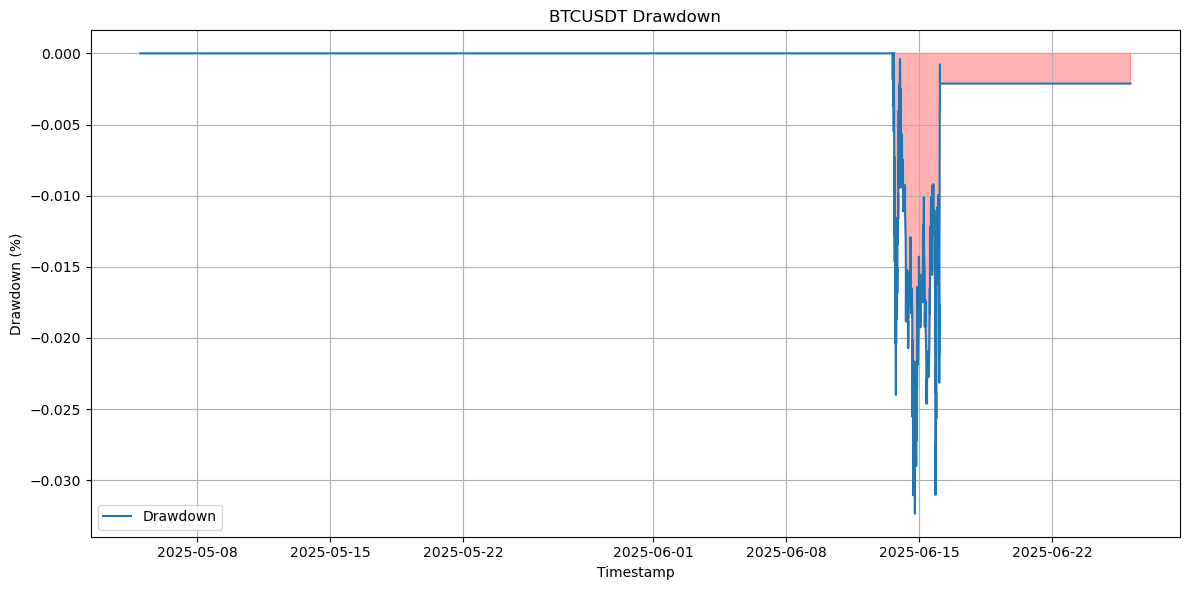

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.95 # Predicted probability above this to go long (buy)
short_threshold = 0.05 # Predicted probability below this to go short (sell)

beta = 3
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 111370.59
Total Return: 11.37%
Total Realized PnL: 25871.34
年化收益 (近似): 112.59%
Maximum Drawdown: -13.63%
Sharpe Ratio (Risk-Free Rate = 0): 321.97
Number of Trades: 6
Win Rate: 66.67%


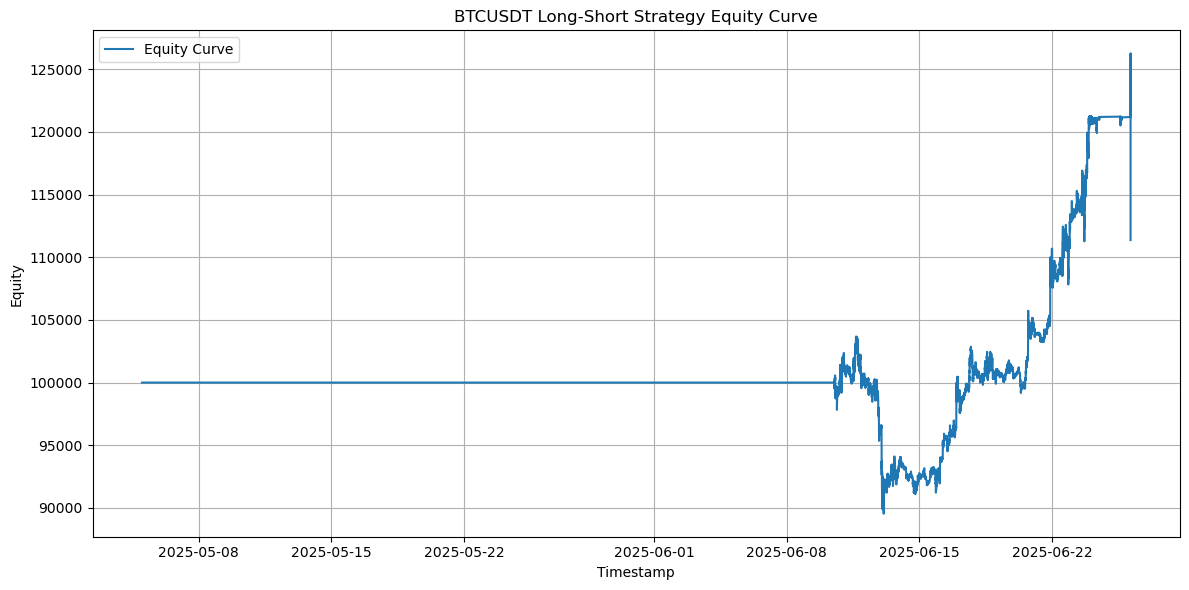

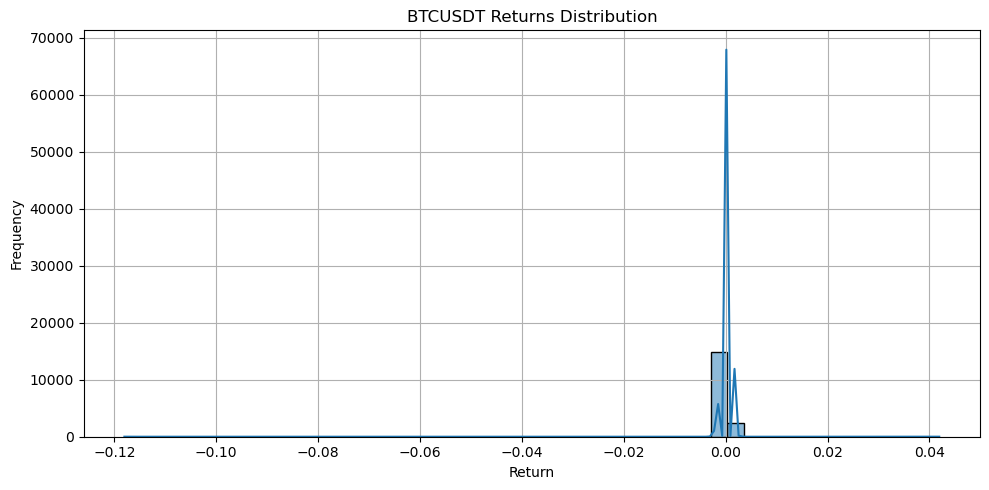

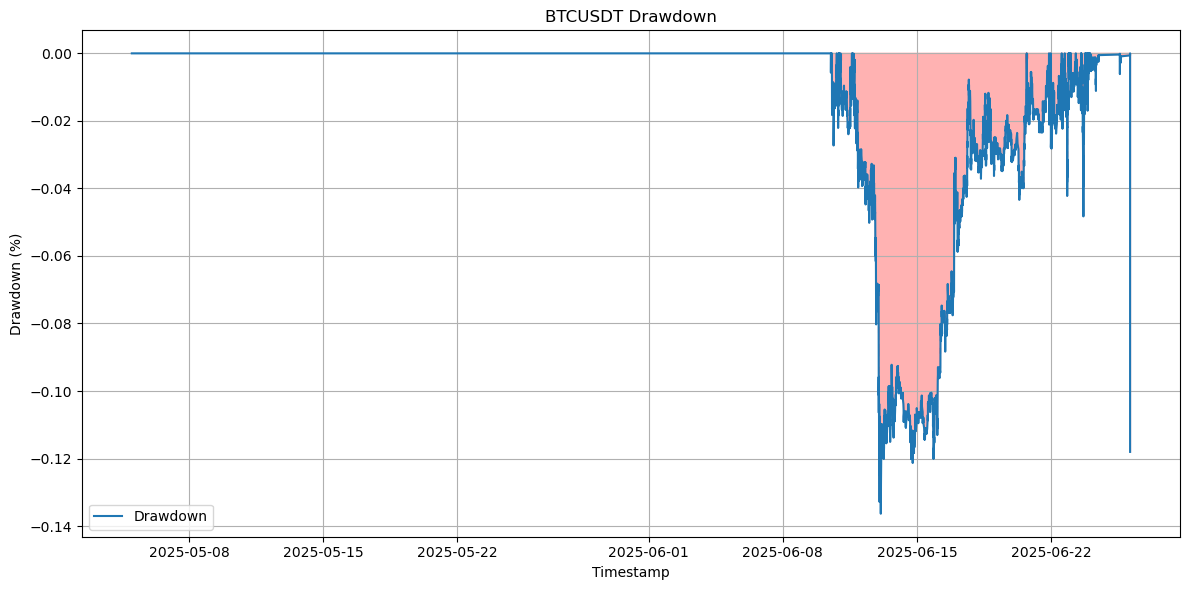

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.85 # Predicted probability above this to go long (buy)
short_threshold = 0.15 # Predicted probability below this to go short (sell)

beta = 55
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [31]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "feat_cal_window": feat_cal_window,
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lag": feat_trans_lag,
#         "feat_norm_window": feat_norm_window,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         "label_alpha": alpha,
#         "label_window": rolling_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#     },
# )

In [32]:
# all_df_processed = a_df_filtered.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_all = all_df_processed[feature_cols]
# y_all = all_df_processed[target_col]
# px_all = all_df_processed['px']
# std_all = all_df_processed['rolling_std']
# timestamps_all = all_df_processed['timestamp'] # 收集时间戳

# a = tab_inc.predict_proba(X_train.values)[:, 1]
# print(a)
# all_tab_inc_test_verify = []
# current_window_results = pd.DataFrame({
#     'timestamp': timestamps_all,
#     'symbol': "tst", # 如果有多个股票，收集 symbol 是必要的
#     'true_label': y_all,
#     'predicted_prob': tab_inc.predict_proba(X_all.values)[:, 1],
#     'px': px_all, # 收集价格，回测时需要
#     'rolling_std': std_all # 收集波动率，可能用于策略或分析
#     # 添加任何你回测需要的其他数据
# })
# all_tab_inc_test_verify.append(current_window_results)


In [33]:
# rolling_window_size = 10

# final_predictions_df = pd.concat(all_tab_inc_test_verify).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# tabnet_eval = evaluate_with_confidence(
#     y_true=final_predictions_df['true_label'],
#     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
#     model_name="model",
#     lower_thresh=0.05,
#     upper_thresh=0.95,
#     print_report=True,
# )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df